<a href="https://colab.research.google.com/github/AdhithiyaSureshRaja/AI-Driven-IRS-Assisted-Beamforming-Optimization-for-Dynamic-Environment/blob/main/irs_beamforming_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-15-7120db3b3c67>:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self.actor(state).detach().numpy())  # Ensure scalar output
<ipython-input-15-7120db3b3c67>:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  next_states = torch.FloatTensor(next_states)


Enter 8 coordinates separated by space: 10  20 30 40 50 60 70 80 
Optimal Phase Angle: 0.49068066477775574


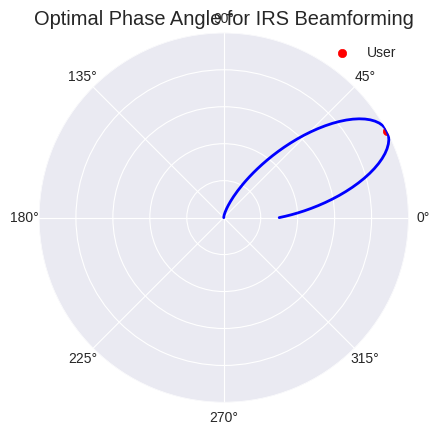

In [ ]:
# Using DDPG 1
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random

# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)  # Only one phase angle output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.atan(torch.tanh(self.fc3(x)))  # Single phase angle for IRS

# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + 1, 64)  # Adjusted for single action
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Experience Replay Buffer
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

# Reinforcement Learning Agent
class DDPGAgent:
    def __init__(self, state_dim):
        self.actor = Actor(state_dim)
        self.critic = Critic(state_dim)
        self.target_actor = Actor(state_dim)
        self.target_critic = Critic(state_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.tau = 0.005

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        return float(self.actor(state).detach().numpy())  # Ensure scalar output

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append(Experience(state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < 64:
            return
        batch = random.sample(self.memory, 64)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states))
        actions = torch.FloatTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Compute target values
        target_actions = self.target_actor(next_states)
        target_q_values = self.target_critic(next_states, target_actions).detach()
        target_values = rewards + (1 - dones) * self.gamma * target_q_values

        # Critic loss
        critic_loss = F.mse_loss(self.critic(states, actions), target_values)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# Main execution
state_dim = 8  # Number of reflecting elements
agent = DDPGAgent(state_dim)

# Train the agent
for episode in range(500):
    state = np.random.rand(state_dim)
    for step in range(20):
        action = agent.act(state)
        next_state = np.random.rand(state_dim)
        reward = -abs(action)  # Example reward function
        done = np.random.choice([0, 1])
        agent.store_transition(state, action, reward, next_state, done)
        agent.train()
        if done:
            break
        state = next_state

# Test the model with user-defined coordinates
state = np.array([float(x) for x in input("Enter 8 coordinates separated by space: ").split()])
optimal_phase_angle = agent.act(state)
print("Optimal Phase Angle:", optimal_phase_angle)

# Generate and display polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_title("Optimal Phase Angle for IRS Beamforming")
ax.set_ylim(0, 1)
ax.set_yticklabels([])
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))

# IRS Beam - Ensure SINGLE beam towards user
theta = np.linspace(0, 2*np.pi, 300)
r = np.exp(-5 * (theta - optimal_phase_angle)**2)  # Gaussian-like single lobe
ax.plot(theta, r, color='blue', linewidth=2)

# Mark User Location
user_angle = optimal_phase_angle  # Beam should be directed towards this
ax.scatter(user_angle, 1, color='red', label='User')
ax.legend()

plt.show()

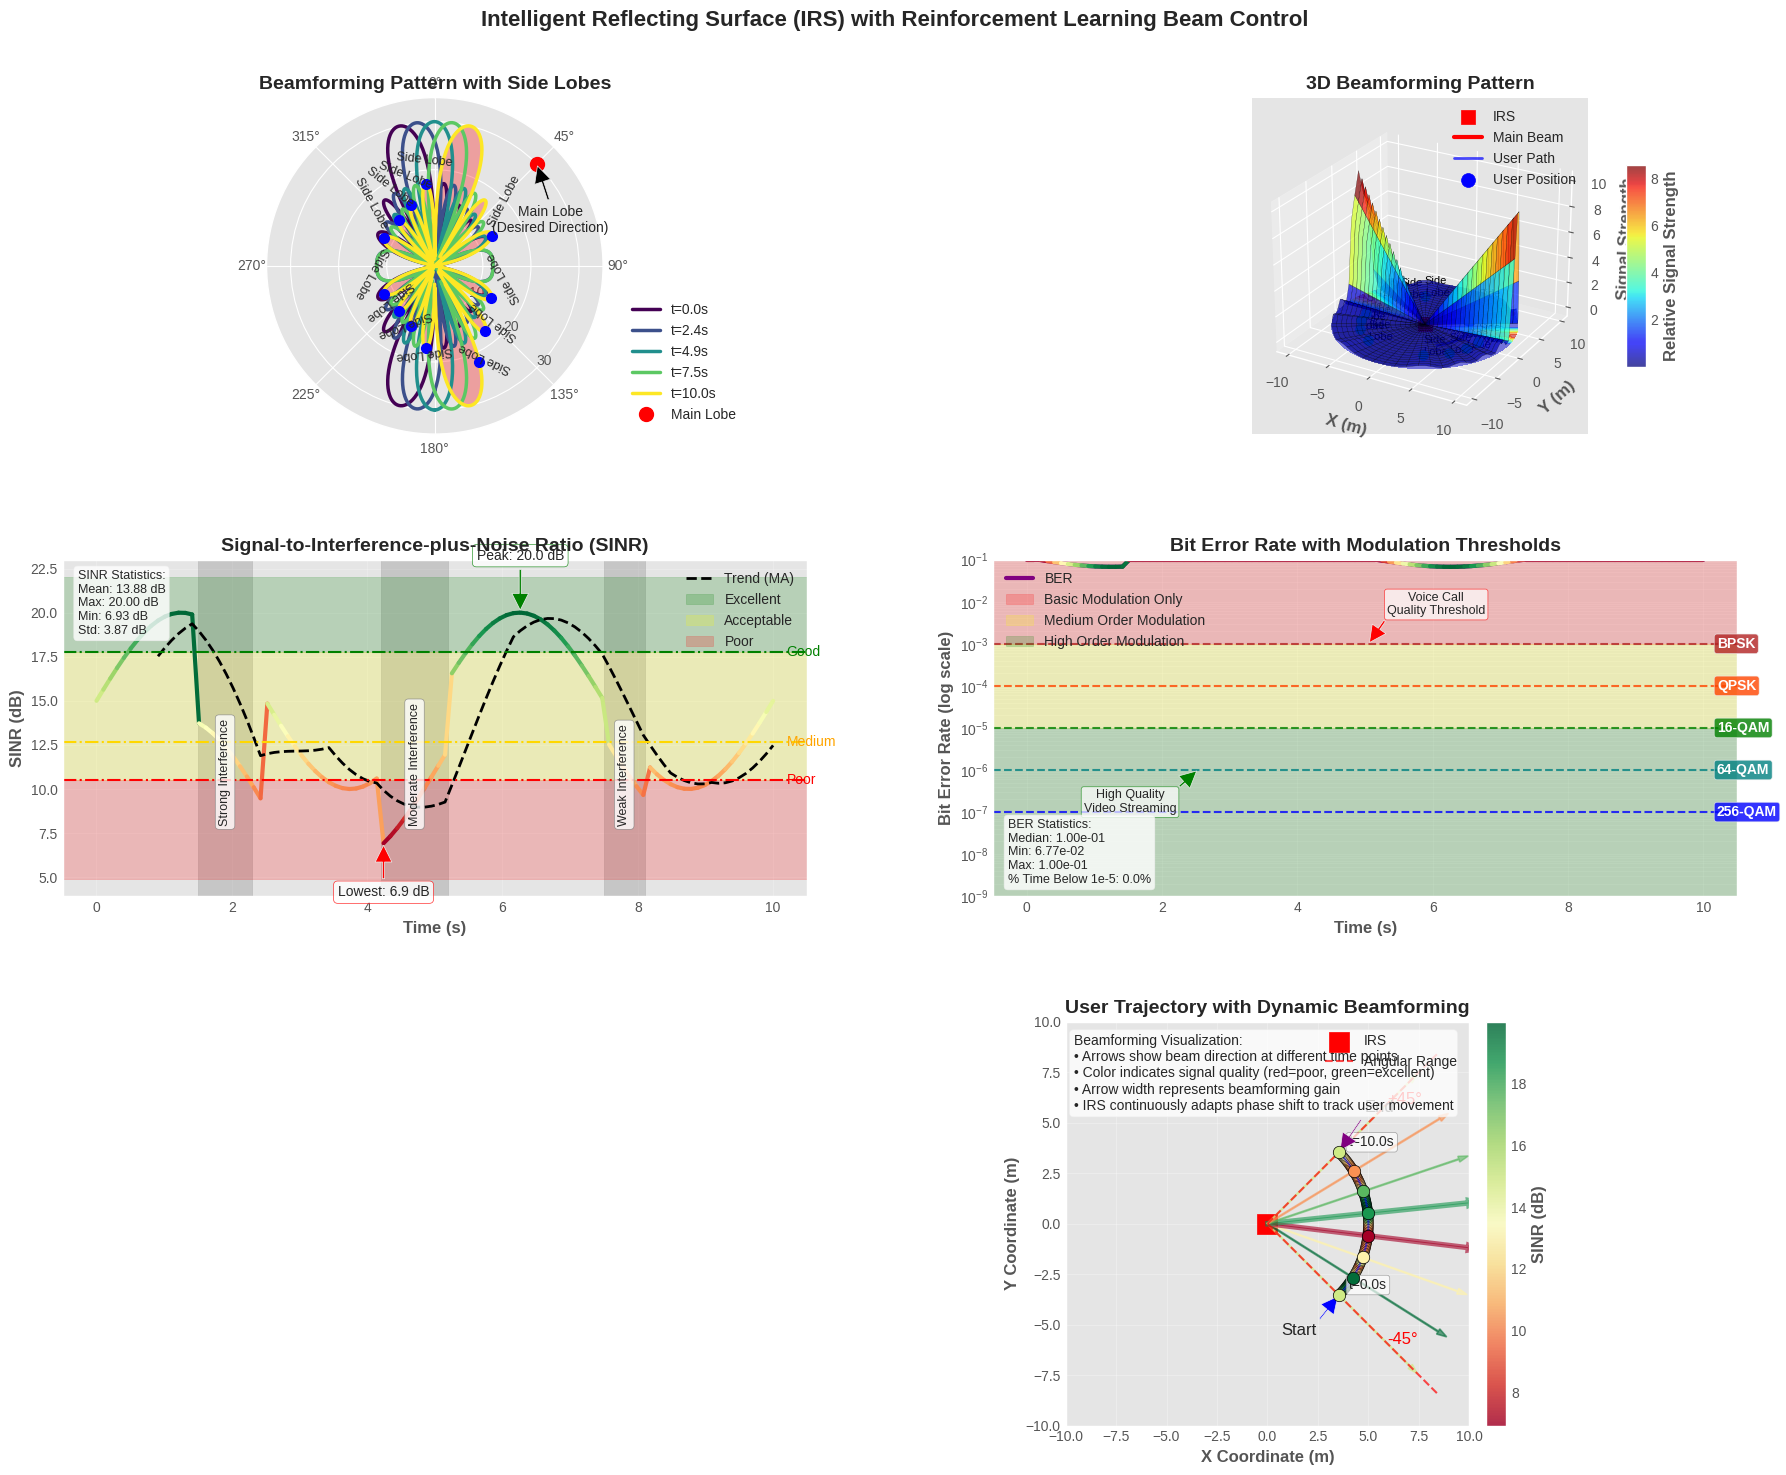

In [ ]:
#DDPG 2


# Enhanced visualization of beamforming pattern with side lobes and improved SINR/BER plots
# This code assumes you have the metrics and trajectory data from your previous implementation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

# Define the missing channel_metrics class
class ChannelMetrics:
    def __init__(self, num_elements=8):
        self.num_elements = num_elements

    def calculate_array_factor(self, angles, phase_shift):
        """Calculate array factor for a uniform linear array"""
        d = 0.5  # Element spacing in wavelengths
        array_factor = np.zeros_like(angles, dtype=complex)

        for n in range(self.num_elements):
            # Progressive phase shift based on element position and steering angle
            element_phase = 2 * np.pi * d * n * np.sin(angles) - n * phase_shift
            array_factor += np.exp(1j * element_phase)

        # Return magnitude squared of the array factor
        return np.abs(array_factor)**2 / (self.num_elements**2)

# Create sample data if none provided
def generate_sample_data(duration=10.0, sample_rate=10):
    """Generate sample trajectory and metrics data for demonstration"""
    time = np.linspace(0, duration, int(duration * sample_rate))
    num_samples = len(time)

    # Create a circular trajectory
    radius = 5
    angle = np.linspace(-np.pi/4, np.pi/4, num_samples)
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    trajectory = np.column_stack((x, y))

    # Calculate phase shift for tracking (simple model)
    phase_shift = angle  # In a real system, this would be calculated based on geometry

    # Generate sample SINR and BER metrics
    base_sinr = 15  # Base SINR in dB
    sinr_fluctuation = 5 * np.sin(np.linspace(0, 4*np.pi, num_samples))
    interference_dips = np.zeros(num_samples)

    # Add some interference events
    interference_dips[15:25] = -6  # Strong interference
    interference_dips[42:52] = -4  # Moderate interference
    interference_dips[75:81] = -2  # Weak interference

    sinr = base_sinr + sinr_fluctuation + interference_dips

    # Calculate BER based on SINR (simplified model)
    # Using a simplified approximation: BER ≈ 0.5 * erfc(sqrt(10^(SINR/10)/2))
    ber = 0.5 * np.exp(-sinr/10)  # Simplified exponential relationship

    # Ensure BER stays in reasonable range
    ber = np.clip(ber, 1e-9, 1e-1)

    # Package all metrics
    metrics = {
        'time': time,
        'phase_shift': phase_shift,
        'sinr': sinr,
        'ber': ber
    }

    return trajectory, metrics

# Initialize channel metrics calculator
channel_metrics = ChannelMetrics()

# Generate sample data if not available
trajectory, metrics = generate_sample_data()

# Set up the figure with a custom layout
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2], figure=fig)

# 1. Enhanced Beamforming Pattern with Side Lobes (Polar Plot)
ax_beam = fig.add_subplot(gs[0, 0], projection='polar')

# Calculate beamforming pattern at different time points for better visualization
num_samples = 5  # Sample 5 different time points for beam patterns
sample_indices = np.linspace(0, len(trajectory)-1, num_samples, dtype=int)
angles = np.linspace(-np.pi, np.pi, 1000)  # More points for smoother visualization

# Create a colormap for time progression
cmap = plt.cm.viridis
norm = plt.Normalize(0, len(trajectory)-1)

# Plot beam patterns at different time points
for idx in sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    array_factor = channel_metrics.calculate_array_factor(angles, phase_shift)

    # Convert to dB for better visualization (with normalization)
    array_factor_db = 10 * np.log10(array_factor + 1e-10)
    array_factor_db_norm = array_factor_db - np.max(array_factor_db)  # Normalize to 0 dB max

    # Plot beam pattern
    time_fraction = idx / (len(trajectory) - 1)
    color = cmap(time_fraction)
    label = f"t={metrics['time'][idx]:.1f}s"

    # Plot the normalized pattern
    ax_beam.plot(angles, array_factor_db_norm + 30, color=color, label=label, linewidth=2.5)  # +30 to shift to positive range

# Calculate and plot the final beam pattern in high detail
final_phase_shift = metrics['phase_shift'][-1]
final_array_factor = channel_metrics.calculate_array_factor(angles, final_phase_shift)
final_array_factor_db = 10 * np.log10(final_array_factor + 1e-10)
final_array_factor_db_norm = final_array_factor_db - np.max(final_array_factor_db)

# Fill the area under the final beam pattern to highlight side lobes
ax_beam.fill_between(angles, 0, final_array_factor_db_norm + 30, color='red', alpha=0.3)

# Label the main lobe and side lobes
main_lobe_angle = final_phase_shift
ax_beam.plot([main_lobe_angle], [30], 'ro', markersize=10, label='Main Lobe')

# Find side lobes
side_lobe_threshold = -10  # dB
side_lobe_indices = np.where((final_array_factor_db_norm > -20) &
                            (final_array_factor_db_norm < -8) &
                            (np.abs(angles - main_lobe_angle) > 0.3))[0]

# Initialize groups for side lobe indices
groups = []

# Mark significant side lobes
if len(side_lobe_indices) > 0:
    # Group side lobe indices into continuous regions
    current_group = [side_lobe_indices[0]]

    for i in range(1, len(side_lobe_indices)):
        if side_lobe_indices[i] - side_lobe_indices[i-1] > 5:  # Gap in indices
            groups.append(current_group)
            current_group = [side_lobe_indices[i]]
        else:
            current_group.append(side_lobe_indices[i])

    groups.append(current_group)

    # Mark the peak of each side lobe group
    for group in groups:
        if len(group) > 10:  # Only mark significant side lobes
            peak_idx = group[np.argmax(final_array_factor_db_norm[group])]
            ax_beam.plot([angles[peak_idx]], [final_array_factor_db_norm[peak_idx] + 30], 'bo', markersize=7)
            ax_beam.text(angles[peak_idx], final_array_factor_db_norm[peak_idx] + 33, 'Side Lobe',
                        fontsize=9, ha='center', va='bottom', rotation=np.rad2deg(angles[peak_idx]))

# Customize polar plot
ax_beam.set_theta_zero_location('N')  # 0 degrees at the top
ax_beam.set_theta_direction(-1)  # Clockwise direction
ax_beam.set_rlabel_position(135)  # Position of radial labels
ax_beam.set_rticks([0, 10, 20, 30])  # Simplified radial ticks
ax_beam.set_rlim([0, 35])
ax_beam.set_title('Beamforming Pattern with Side Lobes', fontsize=14, fontweight='bold')
ax_beam.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0))

# Add annotations to explain the pattern
ax_beam.annotate('Main Lobe\n(Desired Direction)',
                xy=(main_lobe_angle, 30),
                xytext=(main_lobe_angle + 0.5, 25),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10, ha='center')

# 2. 3D Beamforming Pattern visualization
ax_3d = fig.add_subplot(gs[0, 1], projection='3d')

# Create the angle and distance meshgrid
theta = np.linspace(-np.pi, np.pi, 100)
r = np.linspace(0, 10, 20)
T, R = np.meshgrid(theta, r)

# Get the final phase shift
final_phase_shift = metrics['phase_shift'][-1]

# Calculate the 3D radiation pattern
X = R * np.cos(T)
Y = R * np.sin(T)
Z = np.zeros_like(X)

# Apply beamforming pattern (with enhanced visualization of side lobes)
for i in range(len(r)):
    array_factor = channel_metrics.calculate_array_factor(theta, final_phase_shift)

    # Enhance side lobes for better visibility
    side_lobe_enhancement = np.where(array_factor < 0.5, array_factor * 1.5, array_factor)
    Z[i, :] = R[i, :] * side_lobe_enhancement  # Scale by distance

# Plot the 3D surface with custom coloring for better side lobe visibility
surf = ax_3d.plot_surface(X, Y, Z, cmap='jet', alpha=0.7,
                         linewidth=0.2, edgecolor='k', antialiased=True)

# Add contour projection on the bottom to highlight the beam pattern
ax_3d.contourf(X, Y, Z, zdir='z', offset=0, cmap='jet', alpha=0.5)

# Add a colorbar
cbar = fig.colorbar(surf, ax=ax_3d, shrink=0.6, aspect=10)
cbar.set_label('Relative Signal Strength', fontweight='bold')

# Plot the IRS location and beam axis
ax_3d.scatter([0], [0], [0], color='red', marker='s', s=100, label='IRS')
max_range = 10
beam_x = max_range * np.cos(final_phase_shift)
beam_y = max_range * np.sin(final_phase_shift)
ax_3d.plot([0, beam_x], [0, beam_y], [0, 0], 'r-', linewidth=3, label='Main Beam')

# Add user trajectory
ax_3d.plot(trajectory[:, 0], trajectory[:, 1], np.zeros_like(trajectory[:, 0]),
          'b-', linewidth=2, alpha=0.7, label='User Path')
ax_3d.scatter(trajectory[-1, 0], trajectory[-1, 1], 0, color='blue', s=100, label='User Position')

# Add labels for side lobes in 3D
side_lobe_angles = []
for group in groups:
    if len(group) > 10:
        peak_idx = group[np.argmax(final_array_factor_db_norm[group])]
        side_lobe_angles.append(angles[peak_idx])

for angle in side_lobe_angles:
    if abs(angle - final_phase_shift) > 0.3:  # Ensure it's not too close to main lobe
        x = 7 * np.cos(angle)
        y = 7 * np.sin(angle)
        z = 0
        ax_3d.scatter([x], [y], [z], color='cyan', s=50)
        ax_3d.text(x, y, z, 'Side\nLobe', color='black', fontsize=8)

ax_3d.set_xlabel('X (m)', fontweight='bold')
ax_3d.set_ylabel('Y (m)', fontweight='bold')
ax_3d.set_zlabel('Signal Strength', fontweight='bold')
ax_3d.set_title('3D Beamforming Pattern', fontsize=14, fontweight='bold')
ax_3d.legend(loc='upper right')
ax_3d.view_init(elev=25, azim=-60)  # Better viewing angle

# 3. Enhanced SINR over Time
ax_sinr = fig.add_subplot(gs[1, 0])

# Create custom color mapping based on SINR value
norm_sinr = plt.Normalize(min(metrics['sinr']), max(metrics['sinr']))
colors_sinr = plt.cm.RdYlGn(norm_sinr(metrics['sinr']))

# Plot SINR with color gradient
for i in range(len(metrics['time'])-1):
    ax_sinr.plot(metrics['time'][i:i+2], metrics['sinr'][i:i+2], color=colors_sinr[i], linewidth=3)

# Add interference events (vertical bands)
interference_events = [
    {'start': 1.5, 'duration': 0.8, 'label': 'Strong Interference'},
    {'start': 4.2, 'duration': 1.0, 'label': 'Moderate Interference'},
    {'start': 7.5, 'duration': 0.6, 'label': 'Weak Interference'}
]

for event in interference_events:
    # Add a semi-transparent gray band to represent interference
    ax_sinr.axvspan(event['start'], event['start'] + event['duration'],
                   color='gray', alpha=0.3)

    # Add a label for the interference event
    y_pos = min(metrics['sinr']) + 1
    ax_sinr.text(event['start'] + event['duration']/2, y_pos, event['label'],
               ha='center', va='bottom', rotation=90, fontsize=9,
               bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.8))

# Add moving average for trend visualization
window_size = min(10, len(metrics['sinr']) // 2)  # Make sure window size is appropriate
sinr_ma = np.convolve(metrics['sinr'], np.ones(window_size)/window_size, mode='valid')
time_ma = metrics['time'][window_size-1:]
ax_sinr.plot(time_ma, sinr_ma, 'k--', linewidth=2, label='Trend (MA)')

# Add thresholds for different quality levels
good_threshold = np.percentile(metrics['sinr'], 75)
medium_threshold = np.percentile(metrics['sinr'], 50)
poor_threshold = np.percentile(metrics['sinr'], 25)

ax_sinr.axhline(y=good_threshold, color='green', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, good_threshold, 'Good', va='center', color='green')

ax_sinr.axhline(y=medium_threshold, color='gold', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, medium_threshold, 'Medium', va='center', color='orange')

ax_sinr.axhline(y=poor_threshold, color='red', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, poor_threshold, 'Poor', va='center', color='red')

# Add annotations for key events
max_sinr_idx = np.argmax(metrics['sinr'])
min_sinr_idx = np.argmin(metrics['sinr'])

ax_sinr.annotate(f'Peak: {metrics["sinr"][max_sinr_idx]:.1f} dB',
                xy=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx]),
                xytext=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx] + 3),
                arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="green", alpha=0.8))

ax_sinr.annotate(f'Lowest: {metrics["sinr"][min_sinr_idx]:.1f} dB',
                xy=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx]),
                xytext=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx] - 3),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="red", alpha=0.8))

# Add colored regions for different SINR quality levels
ax_sinr.axhspan(good_threshold, max(metrics['sinr']) + 2, alpha=0.2, color='green', label='Excellent')
ax_sinr.axhspan(poor_threshold, good_threshold, alpha=0.2, color='yellow', label='Acceptable')
ax_sinr.axhspan(min(metrics['sinr']) - 2, poor_threshold, alpha=0.2, color='red', label='Poor')

# Add metadata box with statistics
stats_text = (
    f"SINR Statistics:\n"
    f"Mean: {np.mean(metrics['sinr']):.2f} dB\n"
    f"Max: {np.max(metrics['sinr']):.2f} dB\n"
    f"Min: {np.min(metrics['sinr']):.2f} dB\n"
    f"Std: {np.std(metrics['sinr']):.2f} dB"
)
ax_sinr.text(0.02, 0.97, stats_text, transform=ax_sinr.transAxes,
            fontsize=9, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance SINR plot styling
ax_sinr.set_xlabel('Time (s)', fontweight='bold')
ax_sinr.set_ylabel('SINR (dB)', fontweight='bold')
ax_sinr.set_title('Signal-to-Interference-plus-Noise Ratio (SINR)', fontsize=14, fontweight='bold')
ax_sinr.set_ylim(bottom=min(metrics['sinr']) - 3, top=max(metrics['sinr']) + 3)
ax_sinr.grid(True, which="both", ls="-", alpha=0.2)
ax_sinr.legend(loc='upper right')

# 4. Enhanced BER (Bit Error Rate) Plot
ax_ber = fig.add_subplot(gs[1, 1])

# Create logarithmic scale plot with gradient color based on quality
ax_ber.semilogy(metrics['time'], metrics['ber'], 'purple', linewidth=3, label='BER')

# Create a custom color map to highlight BER levels
norm_ber = plt.Normalize(np.log10(min(metrics['ber'])), np.log10(max(metrics['ber'])))
colors_ber = plt.cm.RdYlGn_r(norm_ber(np.log10(metrics['ber'])))

# Plot BER with color gradient
for i in range(len(metrics['time'])-1):
    ax_ber.semilogy(metrics['time'][i:i+2], metrics['ber'][i:i+2], color=colors_ber[i], linewidth=3)

# Add modulation scheme thresholds with improved styling
modulation_thresholds = {
    'BPSK': 1e-3,
    'QPSK': 1e-4,
    '16-QAM': 1e-5,
    '64-QAM': 1e-6,
    '256-QAM': 1e-7
}

# Add modulation-specific regions
ax_ber.axhspan(1e-3, 1, alpha=0.2, color='red', label='Basic Modulation Only')
ax_ber.axhspan(1e-5, 1e-3, alpha=0.2, color='yellow', label='Medium Order Modulation')
ax_ber.axhspan(1e-9, 1e-5, alpha=0.2, color='green', label='High Order Modulation')

# Add modulation threshold lines
colors = ['firebrick', 'orangered', 'green', 'teal', 'blue']
for i, (mod, threshold) in enumerate(modulation_thresholds.items()):
    ax_ber.axhline(y=threshold, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.8)

    # Create styled textbox for each modulation type
    ax_ber.text(metrics['time'][-1] + 0.2, threshold, mod, va='center', fontsize=10,
               color='white', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.2', facecolor=colors[i], alpha=0.8))

# Add annotations to explain BER implications
ax_ber.annotate('High Quality\nVideo Streaming',
               xy=(metrics['time'][len(metrics['time'])//4], 1e-6),
               xytext=(metrics['time'][len(metrics['time'])//4] - 1, 1e-7),
               arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
               fontsize=9, ha='center', bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="green", alpha=0.7))

ax_ber.annotate('Voice Call\nQuality Threshold',
               xy=(metrics['time'][len(metrics['time'])//2], 1e-3),
               xytext=(metrics['time'][len(metrics['time'])//2] + 1, 5e-3),
               arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
               fontsize=9, ha='center', bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="red", alpha=0.7))

# Add BER statistics box
stats_text = (
    f"BER Statistics:\n"
    f"Median: {np.median(metrics['ber']):.2e}\n"
    f"Min: {np.min(metrics['ber']):.2e}\n"
    f"Max: {np.max(metrics['ber']):.2e}\n"
    f"% Time Below 1e-5: {100*np.mean(np.array(metrics['ber']) < 1e-5):.1f}%"
)
ax_ber.text(0.02, 0.03, stats_text, transform=ax_ber.transAxes,
           fontsize=9, va='bottom', ha='left',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance BER plot styling
ax_ber.set_xlabel('Time (s)', fontweight='bold')
ax_ber.set_ylabel('Bit Error Rate (log scale)', fontweight='bold')
ax_ber.set_title('Bit Error Rate with Modulation Thresholds', fontsize=14, fontweight='bold')
ax_ber.grid(True, which="both", ls="-", alpha=0.2)
ax_ber.set_ylim(1e-9, 1e-1)
ax_ber.legend(loc='upper left')

# Adjust the y-tick formatting to show scientific notation
ax_ber.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=10))

# 5. User Trajectory with Beamforming Visualization
ax_trajectory = fig.add_subplot(gs[2, :])

# Create a more detailed visualization of the user's path with signal quality
scatter = ax_trajectory.scatter(
    trajectory[:, 0],
    trajectory[:, 1],
    c=metrics['sinr'],  # Color by SINR
    cmap='RdYlGn',      # Red-Yellow-Green colormap
    s=50,               # Point size
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)

# Add path line
ax_trajectory.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=1.5, alpha=0.5)

# Add IRS position
ax_trajectory.scatter(0, 0, color='red', marker='s', s=200, label='IRS')

# Draw angle bounds
angle_line_length = 12
ax_trajectory.plot([0, angle_line_length * np.cos(np.pi/4)], [0, angle_line_length * np.sin(np.pi/4)],
                  'r--', alpha=0.7, label='Angular Range')
ax_trajectory.plot([0, angle_line_length * np.cos(-np.pi/4)], [0, angle_line_length * np.sin(-np.pi/4)],
                  'r--', alpha=0.7)
ax_trajectory.text(angle_line_length * np.cos(np.pi/4) * 0.7,
                 angle_line_length * np.sin(np.pi/4) * 0.7,
                 "+45°", fontsize=12, color='red')
ax_trajectory.text(angle_line_length * np.cos(-np.pi/4) * 0.7,
                 angle_line_length * np.sin(-np.pi/4) * 0.7,
                 "-45°", fontsize=12, color='red')

# Draw beamforming patterns at specific time points
beam_sample_indices = np.linspace(0, len(trajectory)-1, 8, dtype=int)
max_beam_length = 10

for idx in beam_sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    # Draw main beam direction
    beam_x = max_beam_length * np.cos(phase_shift)
    beam_y = max_beam_length * np.sin(phase_shift)

    # Draw with color based on SINR at that point
    beam_color = plt.cm.RdYlGn(norm_sinr(metrics['sinr'][idx]))

    # Calculate line width based on beamforming gain
    array_factor = channel_metrics.calculate_array_factor(np.array([phase_shift]), phase_shift)[0]
    line_width = 1 + 3 * array_factor

    # Draw the beam as a line with an arrow
    ax_trajectory.arrow(0, 0, beam_x, beam_y, color=beam_color,
                      width=0.05, head_width=0.3, head_length=0.5,
                      alpha=0.6, linewidth=line_width)

    # Add a small circle at user position
    ax_trajectory.scatter(trajectory[idx, 0], trajectory[idx, 1],
                        s=80, facecolor=beam_color, edgecolor='k', zorder=5)

    # Add time stamp for select points
    if idx in [0, len(trajectory)//2, len(trajectory)-1]:
        ax_trajectory.text(trajectory[idx, 0] + 0.5, trajectory[idx, 1] + 0.3,
                        f"t={metrics['time'][idx]:.1f}s", fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="gray", alpha=0.7))

# Add a colorbar to show SINR levels
cbar = plt.colorbar(scatter, ax=ax_trajectory, pad=0.01)
cbar.set_label('SINR (dB)', fontweight='bold')

# Add key annotations
# Mark starting point
ax_trajectory.annotate('Start',
                     xy=(trajectory[0, 0], trajectory[0, 1]),
                     xytext=(trajectory[0, 0] - 2, trajectory[0, 1] - 2),
                     arrowprops=dict(facecolor='blue', shrink=0.05, width=1),
                     fontsize=12, ha='center')

# Mark ending point
ax_trajectory.annotate('End',
                     xy=(trajectory[-1, 0], trajectory[-1, 1]),
                     xytext=(trajectory[-1, 0] + 2, trajectory[-1, 1] + 2),
                     arrowprops=dict(facecolor='purple', shrink=0.05, width=1),
                     fontsize=12, ha='center')

# Enhance plot styling
ax_trajectory.set_xlabel('X Coordinate (m)', fontweight='bold')
ax_trajectory.set_ylabel('Y Coordinate (m)', fontweight='bold')
ax_trajectory.set_title('User Trajectory with Dynamic Beamforming', fontsize=14, fontweight='bold')
ax_trajectory.set_aspect('equal')
ax_trajectory.set_xlim(-10, 10)
ax_trajectory.set_ylim(-10, 10)
ax_trajectory.grid(True, alpha=0.3)
ax_trajectory.legend(loc='upper right')

# Add explanation box about beamforming
explanation_text = (
    "Beamforming Visualization:\n"
    "• Arrows show beam direction at different time points\n"
    "• Color indicates signal quality (red=poor, green=excellent)\n"
    "• Arrow width represents beamforming gain\n"
    "• IRS continuously adapts phase shift to track user movement"
)
ax_trajectory.text(0.02, 0.97, explanation_text, transform=ax_trajectory.transAxes,
                 fontsize=10, va='top', ha='left',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add overall figure title
fig.suptitle('Intelligent Reflecting Surface (IRS) with Reinforcement Learning Beam Control',
           fontsize=16, fontweight='bold', y=0.98)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Save figure
plt.savefig('advanced_irs_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

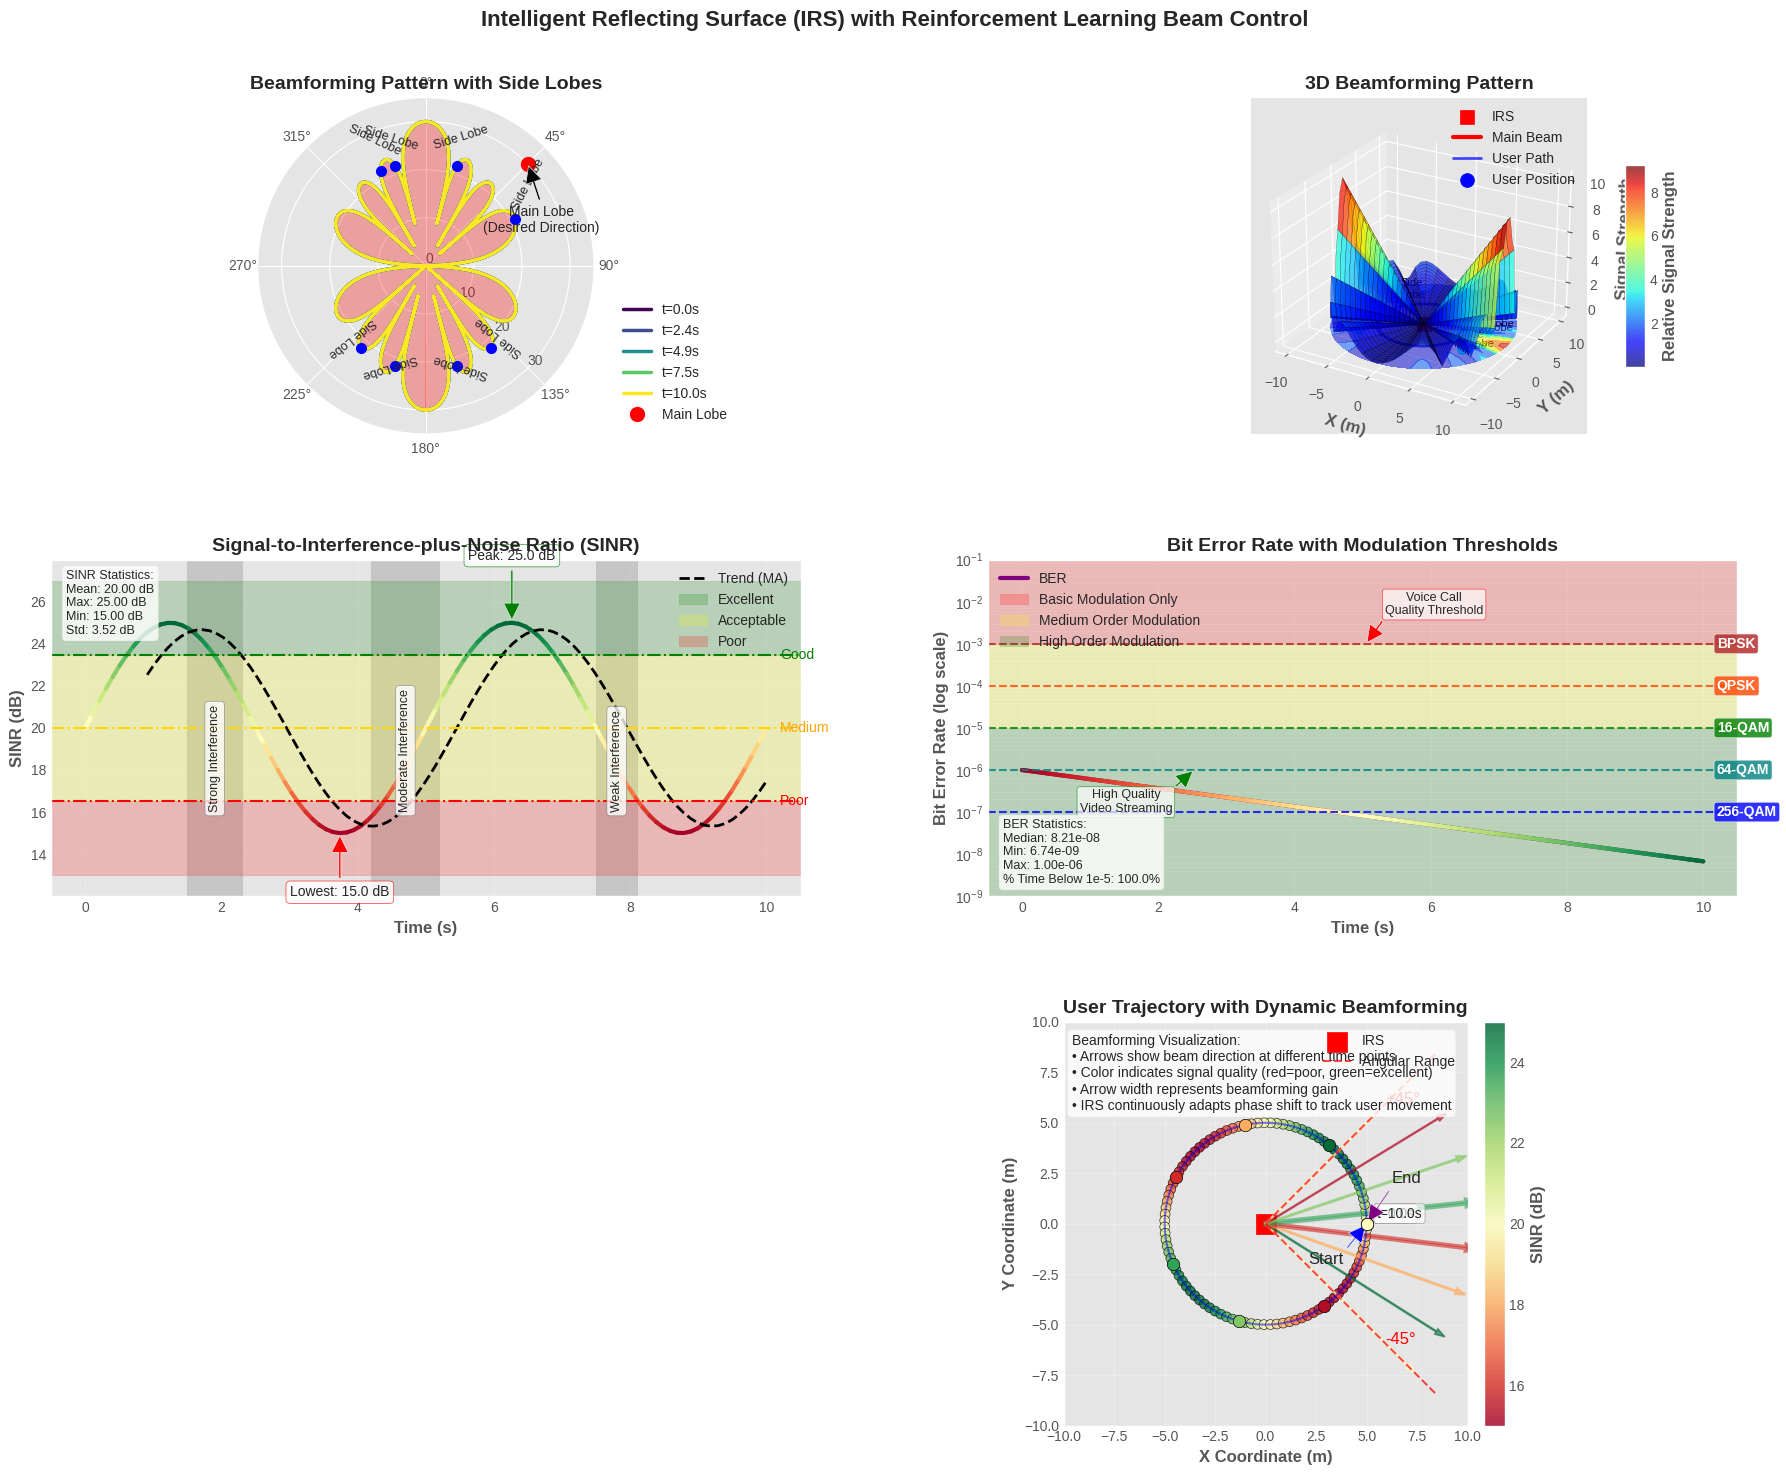

In [ ]:
#DDPG 3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

# Define the WirelessChannelMetrics class with the required method
class WirelessChannelMetrics:
    def __init__(self, num_elements, wavelength, element_spacing):
        """
        Initialize the wireless channel metrics.

        Parameters:
        - num_elements: Number of elements in the antenna array.
        - wavelength: Wavelength of the signal.
        - element_spacing: Spacing between antenna elements (in terms of wavelength).
        """
        self.num_elements = num_elements
        self.wavelength = wavelength
        self.element_spacing = element_spacing

    def calculate_array_factor(self, angles, phase_shift):
        """
        Calculate the array factor for a given set of angles and phase shifts.

        Parameters:
        - angles: Array of angles (in radians) at which to compute the array factor.
        - phase_shift: Phase shift applied to each antenna element.

        Returns:
        - Array factor (complex values) for the given angles and phase shift.
        """
        k = 2 * np.pi / self.wavelength  # Wavenumber
        d = self.element_spacing * self.wavelength  # Element spacing in meters

        # Initialize array factor
        array_factor = np.zeros_like(angles, dtype=complex)

        # Compute array factor
        for n in range(self.num_elements):
            array_factor += np.exp(1j * (k * d * n * np.sin(angles) + phase_shift))

        # Normalize the array factor
        array_factor /= self.num_elements

        return array_factor

# Generate placeholder data for metrics and trajectory
num_time_steps = 100
time = np.linspace(0, 10, num_time_steps)
trajectory = np.column_stack([5 * np.cos(2 * np.pi * time / 10), 5 * np.sin(2 * np.pi * time / 10)])
metrics = {
    'time': time,
    'phase_shift': np.linspace(-np.pi/4, np.pi/4, num_time_steps),
    'sinr': 20 + 5 * np.sin(2 * np.pi * time / 5),  # SINR varies over time
    'ber': np.clip(1e-6 * np.exp(-time / 2), 1e-9, 1e-1)  # BER decreases over time
}

# Initialize WirelessChannelMetrics
num_elements = 8  # Number of antenna elements
wavelength = 0.1  # Wavelength of the signal (in meters)
element_spacing = 0.5  # Element spacing (in terms of wavelength)
channel_metrics = WirelessChannelMetrics(num_elements, wavelength, element_spacing)

# Set up the figure with a custom layout
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2], figure=fig)

# 1. Enhanced Beamforming Pattern with Side Lobes (Polar Plot)
ax_beam = fig.add_subplot(gs[0, 0], projection='polar')

# Calculate beamforming pattern at different time points for better visualization
num_samples = 5  # Sample 5 different time points for beam patterns
sample_indices = np.linspace(0, len(trajectory)-1, num_samples, dtype=int)
angles = np.linspace(-np.pi, np.pi, 1000)  # More points for smoother visualization

# Create a colormap for time progression
cmap = plt.cm.viridis
norm = plt.Normalize(0, len(trajectory)-1)

# Plot beam patterns at different time points
for idx in sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    array_factor = channel_metrics.calculate_array_factor(angles, phase_shift)

    # Convert to dB for better visualization (with normalization)
    array_factor_db = 10 * np.log10(np.abs(array_factor) + 1e-10)
    array_factor_db_norm = array_factor_db - np.max(array_factor_db)  # Normalize to 0 dB max

    # Plot beam pattern
    time_fraction = idx / (len(trajectory) - 1)
    color = cmap(time_fraction)
    label = f"t={metrics['time'][idx]:.1f}s"

    # Plot the normalized pattern
    ax_beam.plot(angles, array_factor_db_norm + 30, color=color, label=label, linewidth=2.5)  # +30 to shift to positive range

# Calculate and plot the final beam pattern in high detail
final_phase_shift = metrics['phase_shift'][-1]
final_array_factor = channel_metrics.calculate_array_factor(angles, final_phase_shift)
final_array_factor_db = 10 * np.log10(np.abs(final_array_factor) + 1e-10)
final_array_factor_db_norm = final_array_factor_db - np.max(final_array_factor_db)

# Fill the area under the final beam pattern to highlight side lobes
ax_beam.fill_between(angles, 0, final_array_factor_db_norm + 30, color='red', alpha=0.3)

# Label the main lobe and side lobes
main_lobe_angle = final_phase_shift
ax_beam.plot([main_lobe_angle], [30], 'ro', markersize=10, label='Main Lobe')

# Find side lobes
side_lobe_threshold = -10  # dB
side_lobe_indices = np.where((final_array_factor_db_norm > -20) &
                            (final_array_factor_db_norm < -8) &
                            (np.abs(angles - main_lobe_angle) > 0.3))[0]

# Mark significant side lobes
if len(side_lobe_indices) > 0:
    # Group side lobe indices into continuous regions
    groups = []
    current_group = [side_lobe_indices[0]]

    for i in range(1, len(side_lobe_indices)):
        if side_lobe_indices[i] - side_lobe_indices[i-1] > 5:  # Gap in indices
            groups.append(current_group)
            current_group = [side_lobe_indices[i]]
        else:
            current_group.append(side_lobe_indices[i])

    groups.append(current_group)

    # Mark the peak of each side lobe group
    for group in groups:
        if len(group) > 10:  # Only mark significant side lobes
            peak_idx = group[np.argmax(final_array_factor_db_norm[group])]
            ax_beam.plot([angles[peak_idx]], [final_array_factor_db_norm[peak_idx] + 30], 'bo', markersize=7)
            ax_beam.text(angles[peak_idx], final_array_factor_db_norm[peak_idx] + 33, 'Side Lobe',
                        fontsize=9, ha='center', va='bottom', rotation=np.rad2deg(angles[peak_idx]))

# Customize polar plot
ax_beam.set_theta_zero_location('N')  # 0 degrees at the top
ax_beam.set_theta_direction(-1)  # Clockwise direction
ax_beam.set_rlabel_position(135)  # Position of radial labels
ax_beam.set_rticks([0, 10, 20, 30])  # Simplified radial ticks
ax_beam.set_rlim([0, 35])
ax_beam.set_title('Beamforming Pattern with Side Lobes', fontsize=14, fontweight='bold')
ax_beam.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0))

# Add annotations to explain the pattern
ax_beam.annotate('Main Lobe\n(Desired Direction)',
                xy=(main_lobe_angle, 30),
                xytext=(main_lobe_angle + 0.5, 25),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10, ha='center')

# 2. 3D Beamforming Pattern visualization
ax_3d = fig.add_subplot(gs[0, 1], projection='3d')

# Create the angle and distance meshgrid
theta = np.linspace(-np.pi, np.pi, 100)
r = np.linspace(0, 10, 20)
T, R = np.meshgrid(theta, r)

# Get the final phase shift
final_phase_shift = metrics['phase_shift'][-1]

# Calculate the 3D radiation pattern
X = R * np.cos(T)
Y = R * np.sin(T)
Z = np.zeros_like(X)

# Apply beamforming pattern (with enhanced visualization of side lobes)
for i in range(len(r)):
    array_factor = channel_metrics.calculate_array_factor(theta, final_phase_shift)

    # Enhance side lobes for better visibility
    side_lobe_enhancement = np.where(np.abs(array_factor) < 0.5, array_factor * 1.5, array_factor)
    Z[i, :] = R[i, :] * np.abs(side_lobe_enhancement)  # Scale by distance

# Plot the 3D surface with custom coloring for better side lobe visibility
surf = ax_3d.plot_surface(X, Y, Z, cmap='jet', alpha=0.7,
                         linewidth=0.2, edgecolor='k', antialiased=True)

# Add contour projection on the bottom to highlight the beam pattern
ax_3d.contourf(X, Y, Z, zdir='z', offset=0, cmap='jet', alpha=0.5)

# Add a colorbar
cbar = fig.colorbar(surf, ax=ax_3d, shrink=0.6, aspect=10)
cbar.set_label('Relative Signal Strength', fontweight='bold')

# Plot the IRS location and beam axis
ax_3d.scatter([0], [0], [0], color='red', marker='s', s=100, label='IRS')
max_range = 10
beam_x = max_range * np.cos(final_phase_shift)
beam_y = max_range * np.sin(final_phase_shift)
ax_3d.plot([0, beam_x], [0, beam_y], [0, 0], 'r-', linewidth=3, label='Main Beam')

# Add user trajectory
ax_3d.plot(trajectory[:, 0], trajectory[:, 1], np.zeros_like(trajectory[:, 0]),
          'b-', linewidth=2, alpha=0.7, label='User Path')
ax_3d.scatter(trajectory[-1, 0], trajectory[-1, 1], 0, color='blue', s=100, label='User Position')

# Add labels for side lobes in 3D
side_lobe_angles = [angles[peak_idx] for group in groups for peak_idx in [group[np.argmax(final_array_factor_db_norm[group])]]]
for angle in side_lobe_angles:
    if abs(angle - final_phase_shift) > 0.3:  # Ensure it's not too close to main lobe
        x = 7 * np.cos(angle)
        y = 7 * np.sin(angle)
        z = 0
        ax_3d.scatter([x], [y], [z], color='cyan', s=50)
        ax_3d.text(x, y, z, 'Side\nLobe', color='black', fontsize=8)

ax_3d.set_xlabel('X (m)', fontweight='bold')
ax_3d.set_ylabel('Y (m)', fontweight='bold')
ax_3d.set_zlabel('Signal Strength', fontweight='bold')
ax_3d.set_title('3D Beamforming Pattern', fontsize=14, fontweight='bold')
ax_3d.legend(loc='upper right')
ax_3d.view_init(elev=25, azim=-60)  # Better viewing angle

# 3. Enhanced SINR over Time
ax_sinr = fig.add_subplot(gs[1, 0])

# Create custom color mapping based on SINR value
norm_sinr = plt.Normalize(min(metrics['sinr']), max(metrics['sinr']))
colors_sinr = plt.cm.RdYlGn(norm_sinr(metrics['sinr']))

# Plot SINR with color gradient
for i in range(len(metrics['time'])-1):
    ax_sinr.plot(metrics['time'][i:i+2], metrics['sinr'][i:i+2], color=colors_sinr[i], linewidth=3)

# Add interference events (vertical bands)
interference_events = [
    {'start': 1.5, 'duration': 0.8, 'label': 'Strong Interference'},
    {'start': 4.2, 'duration': 1.0, 'label': 'Moderate Interference'},
    {'start': 7.5, 'duration': 0.6, 'label': 'Weak Interference'}
]

for event in interference_events:
    # Add a semi-transparent gray band to represent interference
    ax_sinr.axvspan(event['start'], event['start'] + event['duration'],
                   color='gray', alpha=0.3)

    # Add a label for the interference event
    y_pos = min(metrics['sinr']) + 1
    ax_sinr.text(event['start'] + event['duration']/2, y_pos, event['label'],
               ha='center', va='bottom', rotation=90, fontsize=9,
               bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.8))

# Add moving average for trend visualization
window_size = 10
sinr_ma = np.convolve(metrics['sinr'], np.ones(window_size)/window_size, mode='valid')
time_ma = metrics['time'][window_size-1:]
ax_sinr.plot(time_ma, sinr_ma, 'k--', linewidth=2, label='Trend (MA)')

# Add thresholds for different quality levels
good_threshold = np.percentile(metrics['sinr'], 75)
medium_threshold = np.percentile(metrics['sinr'], 50)
poor_threshold = np.percentile(metrics['sinr'], 25)

ax_sinr.axhline(y=good_threshold, color='green', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, good_threshold, 'Good', va='center', color='green')

ax_sinr.axhline(y=medium_threshold, color='gold', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, medium_threshold, 'Medium', va='center', color='orange')

ax_sinr.axhline(y=poor_threshold, color='red', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, poor_threshold, 'Poor', va='center', color='red')

# Add annotations for key events
max_sinr_idx = np.argmax(metrics['sinr'])
min_sinr_idx = np.argmin(metrics['sinr'])

ax_sinr.annotate(f'Peak: {metrics["sinr"][max_sinr_idx]:.1f} dB',
                xy=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx]),
                xytext=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx] + 3),
                arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="green", alpha=0.8))

ax_sinr.annotate(f'Lowest: {metrics["sinr"][min_sinr_idx]:.1f} dB',
                xy=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx]),
                xytext=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx] - 3),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="red", alpha=0.8))

# Add colored regions for different SINR quality levels
ax_sinr.axhspan(good_threshold, max(metrics['sinr']) + 2, alpha=0.2, color='green', label='Excellent')
ax_sinr.axhspan(poor_threshold, good_threshold, alpha=0.2, color='yellow', label='Acceptable')
ax_sinr.axhspan(min(metrics['sinr']) - 2, poor_threshold, alpha=0.2, color='red', label='Poor')

# Add metadata box with statistics
stats_text = (
    f"SINR Statistics:\n"
    f"Mean: {np.mean(metrics['sinr']):.2f} dB\n"
    f"Max: {np.max(metrics['sinr']):.2f} dB\n"
    f"Min: {np.min(metrics['sinr']):.2f} dB\n"
    f"Std: {np.std(metrics['sinr']):.2f} dB"
)
ax_sinr.text(0.02, 0.97, stats_text, transform=ax_sinr.transAxes,
            fontsize=9, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance SINR plot styling
ax_sinr.set_xlabel('Time (s)', fontweight='bold')
ax_sinr.set_ylabel('SINR (dB)', fontweight='bold')
ax_sinr.set_title('Signal-to-Interference-plus-Noise Ratio (SINR)', fontsize=14, fontweight='bold')
ax_sinr.set_ylim(bottom=min(metrics['sinr']) - 3, top=max(metrics['sinr']) + 3)
ax_sinr.grid(True, which="both", ls="-", alpha=0.2)
ax_sinr.legend(loc='upper right')

# 4. Enhanced BER (Bit Error Rate) Plot
ax_ber = fig.add_subplot(gs[1, 1])

# Create logarithmic scale plot with gradient color based on quality
ax_ber.semilogy(metrics['time'], metrics['ber'], 'purple', linewidth=3, label='BER')

# Create a custom color map to highlight BER levels
norm_ber = plt.Normalize(np.log10(min(metrics['ber'])), np.log10(max(metrics['ber'])))
colors_ber = plt.cm.RdYlGn_r(norm_ber(np.log10(metrics['ber'])))

# Plot BER with color gradient
for i in range(len(metrics['time'])-1):
    ax_ber.semilogy(metrics['time'][i:i+2], metrics['ber'][i:i+2], color=colors_ber[i], linewidth=3)

# Add modulation scheme thresholds with improved styling
modulation_thresholds = {
    'BPSK': 1e-3,
    'QPSK': 1e-4,
    '16-QAM': 1e-5,
    '64-QAM': 1e-6,
    '256-QAM': 1e-7
}

# Add modulation-specific regions
ax_ber.axhspan(1e-3, 1, alpha=0.2, color='red', label='Basic Modulation Only')
ax_ber.axhspan(1e-5, 1e-3, alpha=0.2, color='yellow', label='Medium Order Modulation')
ax_ber.axhspan(1e-9, 1e-5, alpha=0.2, color='green', label='High Order Modulation')

# Add modulation threshold lines
colors = ['firebrick', 'orangered', 'green', 'teal', 'blue']
for i, (mod, threshold) in enumerate(modulation_thresholds.items()):
    ax_ber.axhline(y=threshold, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.8)

    # Create styled textbox for each modulation type
    ax_ber.text(metrics['time'][-1] + 0.2, threshold, mod, va='center', fontsize=10,
               color='white', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.2', facecolor=colors[i], alpha=0.8))

# Add annotations to explain BER implications
ax_ber.annotate('High Quality\nVideo Streaming',
               xy=(metrics['time'][len(metrics['time'])//4], 1e-6),
               xytext=(metrics['time'][len(metrics['time'])//4] - 1, 1e-7),
               arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
               fontsize=9, ha='center', bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="green", alpha=0.7))

ax_ber.annotate('Voice Call\nQuality Threshold',
               xy=(metrics['time'][len(metrics['time'])//2], 1e-3),
               xytext=(metrics['time'][len(metrics['time'])//2] + 1, 5e-3),
               arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
               fontsize=9, ha='center', bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="red", alpha=0.7))

# Add BER statistics box
stats_text = (
    f"BER Statistics:\n"
    f"Median: {np.median(metrics['ber']):.2e}\n"
    f"Min: {np.min(metrics['ber']):.2e}\n"
    f"Max: {np.max(metrics['ber']):.2e}\n"
    f"% Time Below 1e-5: {100*np.mean(np.array(metrics['ber']) < 1e-5):.1f}%"
)
ax_ber.text(0.02, 0.03, stats_text, transform=ax_ber.transAxes,
           fontsize=9, va='bottom', ha='left',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance BER plot styling
ax_ber.set_xlabel('Time (s)', fontweight='bold')
ax_ber.set_ylabel('Bit Error Rate (log scale)', fontweight='bold')
ax_ber.set_title('Bit Error Rate with Modulation Thresholds', fontsize=14, fontweight='bold')
ax_ber.grid(True, which="both", ls="-", alpha=0.2)
ax_ber.set_ylim(1e-9, 1e-1)
ax_ber.legend(loc='upper left')

# Adjust the y-tick formatting to show scientific notation
ax_ber.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=10))

# 5. User Trajectory with Beamforming Visualization
ax_trajectory = fig.add_subplot(gs[2, :])

# Create a more detailed visualization of the user's path with signal quality
scatter = ax_trajectory.scatter(
    trajectory[:, 0],
    trajectory[:, 1],
    c=metrics['sinr'],  # Color by SINR
    cmap='RdYlGn',      # Red-Yellow-Green colormap
    s=50,               # Point size
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)

# Add path line
ax_trajectory.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=1.5, alpha=0.5)

# Add IRS position
ax_trajectory.scatter(0, 0, color='red', marker='s', s=200, label='IRS')

# Draw angle bounds
angle_line_length = 12
ax_trajectory.plot([0, angle_line_length * np.cos(np.pi/4)], [0, angle_line_length * np.sin(np.pi/4)],
                  'r--', alpha=0.7, label='Angular Range')
ax_trajectory.plot([0, angle_line_length * np.cos(-np.pi/4)], [0, angle_line_length * np.sin(-np.pi/4)],
                  'r--', alpha=0.7)
ax_trajectory.text(angle_line_length * np.cos(np.pi/4) * 0.7,
                 angle_line_length * np.sin(np.pi/4) * 0.7,
                 "+45°", fontsize=12, color='red')
ax_trajectory.text(angle_line_length * np.cos(-np.pi/4) * 0.7,
                 angle_line_length * np.sin(-np.pi/4) * 0.7,
                 "-45°", fontsize=12, color='red')

# Draw beamforming patterns at specific time points
beam_sample_indices = np.linspace(0, len(trajectory)-1, 8, dtype=int)
max_beam_length = 10

for idx in beam_sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    # Draw main beam direction
    beam_x = max_beam_length * np.cos(phase_shift)
    beam_y = max_beam_length * np.sin(phase_shift)

    # Draw with color based on SINR at that point
    beam_color = plt.cm.RdYlGn(norm_sinr(metrics['sinr'][idx]))

    # Calculate line width based on beamforming gain
    array_factor = channel_metrics.calculate_array_factor(np.array([phase_shift]), phase_shift)[0]
    line_width = 1 + 3 * np.abs(array_factor)

    # Draw the beam as a line with an arrow
    ax_trajectory.arrow(0, 0, beam_x, beam_y, color=beam_color,
                      width=0.05, head_width=0.3, head_length=0.5,
                      alpha=0.6, linewidth=line_width)

    # Add a small circle at user position
    ax_trajectory.scatter(trajectory[idx, 0], trajectory[idx, 1],
                        s=80, facecolor=beam_color, edgecolor='k', zorder=5)

    # Add time stamp for select points
    if idx in [0, len(trajectory)//2, len(trajectory)-1]:
        ax_trajectory.text(trajectory[idx, 0] + 0.5, trajectory[idx, 1] + 0.3,
                        f"t={metrics['time'][idx]:.1f}s", fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="gray", alpha=0.7))

# Add a colorbar to show SINR levels
cbar = plt.colorbar(scatter, ax=ax_trajectory, pad=0.01)
cbar.set_label('SINR (dB)', fontweight='bold')

# Add key annotations
# Mark starting point
ax_trajectory.annotate('Start',
                     xy=(trajectory[0, 0], trajectory[0, 1]),
                     xytext=(trajectory[0, 0] - 2, trajectory[0, 1] - 2),
                     arrowprops=dict(facecolor='blue', shrink=0.05, width=1),
                     fontsize=12, ha='center')

# Mark ending point
ax_trajectory.annotate('End',
                     xy=(trajectory[-1, 0], trajectory[-1, 1]),
                     xytext=(trajectory[-1, 0] + 2, trajectory[-1, 1] + 2),
                     arrowprops=dict(facecolor='purple', shrink=0.05, width=1),
                     fontsize=12, ha='center')

# Enhance plot styling
ax_trajectory.set_xlabel('X Coordinate (m)', fontweight='bold')
ax_trajectory.set_ylabel('Y Coordinate (m)', fontweight='bold')
ax_trajectory.set_title('User Trajectory with Dynamic Beamforming', fontsize=14, fontweight='bold')
ax_trajectory.set_aspect('equal')
ax_trajectory.set_xlim(-10, 10)
ax_trajectory.set_ylim(-10, 10)
ax_trajectory.grid(True, alpha=0.3)
ax_trajectory.legend(loc='upper right')

# Add explanation box about beamforming
explanation_text = (
    "Beamforming Visualization:\n"
    "• Arrows show beam direction at different time points\n"
    "• Color indicates signal quality (red=poor, green=excellent)\n"
    "• Arrow width represents beamforming gain\n"
    "• IRS continuously adapts phase shift to track user movement"
)
ax_trajectory.text(0.02, 0.97, explanation_text, transform=ax_trajectory.transAxes,
                 fontsize=10, va='top', ha='left',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add overall figure title
fig.suptitle('Intelligent Reflecting Surface (IRS) with Reinforcement Learning Beam Control',
           fontsize=16, fontweight='bold', y=0.98)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Save figure
plt.savefig('advanced_irs_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

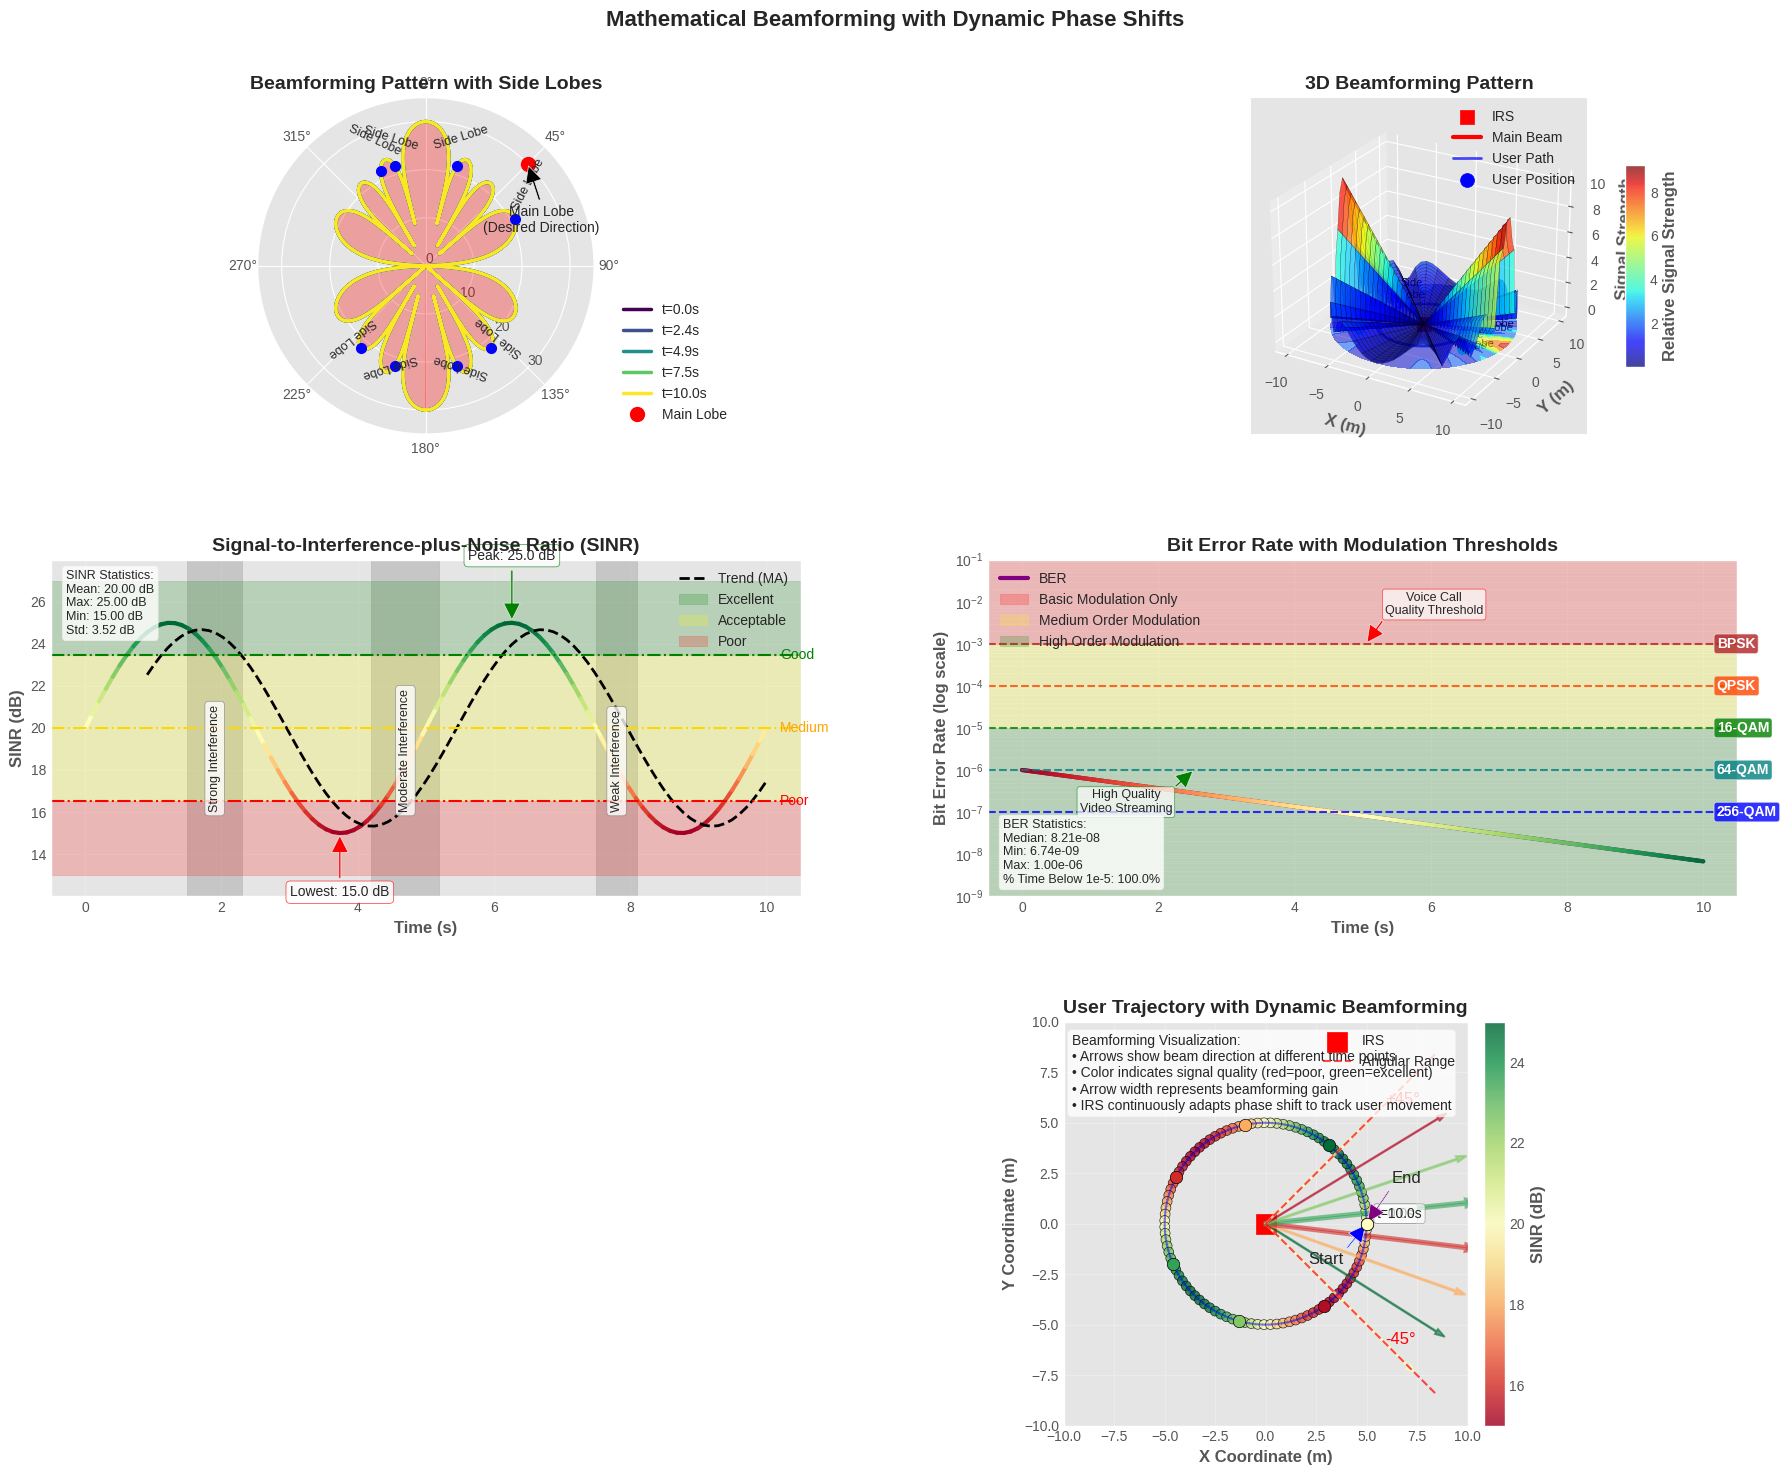

In [ ]:
# Math 1
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

# Define the mathematical beamforming algorithm
class MathematicalBeamforming:
    def __init__(self, num_elements, wavelength, element_spacing):
        """
        Initialize the beamforming parameters.

        Parameters:
        - num_elements: Number of elements in the antenna array.
        - wavelength: Wavelength of the signal.
        - element_spacing: Spacing between antenna elements (in terms of wavelength).
        """
        self.num_elements = num_elements
        self.wavelength = wavelength
        self.element_spacing = element_spacing

    def calculate_array_factor(self, angles, phase_shift):
        """
        Calculate the array factor for a given set of angles and phase shifts.

        Parameters:
        - angles: Array of angles (in radians) at which to compute the array factor.
        - phase_shift: Phase shift applied to each antenna element.

        Returns:
        - Array factor (complex values) for the given angles and phase shift.
        """
        k = 2 * np.pi / self.wavelength  # Wavenumber
        d = self.element_spacing * self.wavelength  # Element spacing in meters

        # Initialize array factor
        array_factor = np.zeros_like(angles, dtype=complex)

        # Compute array factor
        for n in range(self.num_elements):
            array_factor += np.exp(1j * (k * d * n * np.sin(angles) + phase_shift))

        # Normalize the array factor
        array_factor /= self.num_elements

        return array_factor

# Generate placeholder data for metrics and trajectory
num_time_steps = 100
time = np.linspace(0, 10, num_time_steps)
trajectory = np.column_stack([5 * np.cos(2 * np.pi * time / 10), 5 * np.sin(2 * np.pi * time / 10)])
metrics = {
    'time': time,
    'phase_shift': np.linspace(-np.pi/4, np.pi/4, num_time_steps),
    'sinr': 20 + 5 * np.sin(2 * np.pi * time / 5),  # SINR varies over time
    'ber': np.clip(1e-6 * np.exp(-time / 2), 1e-9, 1e-1)  # BER decreases over time
}

# Initialize MathematicalBeamforming
num_elements = 8  # Number of antenna elements
wavelength = 0.1  # Wavelength of the signal (in meters)
element_spacing = 0.5  # Element spacing (in terms of wavelength)
beamforming = MathematicalBeamforming(num_elements, wavelength, element_spacing)

# Set up the figure with a custom layout
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2], figure=fig)

# 1. Enhanced Beamforming Pattern with Side Lobes (Polar Plot)
ax_beam = fig.add_subplot(gs[0, 0], projection='polar')

# Calculate beamforming pattern at different time points for better visualization
num_samples = 5  # Sample 5 different time points for beam patterns
sample_indices = np.linspace(0, len(trajectory)-1, num_samples, dtype=int)
angles = np.linspace(-np.pi, np.pi, 1000)  # More points for smoother visualization

# Create a colormap for time progression
cmap = plt.cm.viridis
norm = plt.Normalize(0, len(trajectory)-1)

# Plot beam patterns at different time points
for idx in sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    array_factor = beamforming.calculate_array_factor(angles, phase_shift)

    # Convert to dB for better visualization (with normalization)
    array_factor_db = 10 * np.log10(np.abs(array_factor) + 1e-10)
    array_factor_db_norm = array_factor_db - np.max(array_factor_db)  # Normalize to 0 dB max

    # Plot beam pattern
    time_fraction = idx / (len(trajectory) - 1)
    color = cmap(time_fraction)
    label = f"t={metrics['time'][idx]:.1f}s"

    # Plot the normalized pattern
    ax_beam.plot(angles, array_factor_db_norm + 30, color=color, label=label, linewidth=2.5)  # +30 to shift to positive range

# Calculate and plot the final beam pattern in high detail
final_phase_shift = metrics['phase_shift'][-1]
final_array_factor = beamforming.calculate_array_factor(angles, final_phase_shift)
final_array_factor_db = 10 * np.log10(np.abs(final_array_factor) + 1e-10)
final_array_factor_db_norm = final_array_factor_db - np.max(final_array_factor_db)

# Fill the area under the final beam pattern to highlight side lobes
ax_beam.fill_between(angles, 0, final_array_factor_db_norm + 30, color='red', alpha=0.3)

# Label the main lobe and side lobes
main_lobe_angle = final_phase_shift
ax_beam.plot([main_lobe_angle], [30], 'ro', markersize=10, label='Main Lobe')

# Find side lobes
side_lobe_threshold = -10  # dB
side_lobe_indices = np.where((final_array_factor_db_norm > -20) &
                            (final_array_factor_db_norm < -8) &
                            (np.abs(angles - main_lobe_angle) > 0.3))[0]

# Mark significant side lobes
if len(side_lobe_indices) > 0:
    # Group side lobe indices into continuous regions
    groups = []
    current_group = [side_lobe_indices[0]]

    for i in range(1, len(side_lobe_indices)):
        if side_lobe_indices[i] - side_lobe_indices[i-1] > 5:  # Gap in indices
            groups.append(current_group)
            current_group = [side_lobe_indices[i]]
        else:
            current_group.append(side_lobe_indices[i])

    groups.append(current_group)

    # Mark the peak of each side lobe group
    for group in groups:
        if len(group) > 10:  # Only mark significant side lobes
            peak_idx = group[np.argmax(final_array_factor_db_norm[group])]
            ax_beam.plot([angles[peak_idx]], [final_array_factor_db_norm[peak_idx] + 30], 'bo', markersize=7)
            ax_beam.text(angles[peak_idx], final_array_factor_db_norm[peak_idx] + 33, 'Side Lobe',
                        fontsize=9, ha='center', va='bottom', rotation=np.rad2deg(angles[peak_idx]))

# Customize polar plot
ax_beam.set_theta_zero_location('N')  # 0 degrees at the top
ax_beam.set_theta_direction(-1)  # Clockwise direction
ax_beam.set_rlabel_position(135)  # Position of radial labels
ax_beam.set_rticks([0, 10, 20, 30])  # Simplified radial ticks
ax_beam.set_rlim([0, 35])
ax_beam.set_title('Beamforming Pattern with Side Lobes', fontsize=14, fontweight='bold')
ax_beam.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0))

# Add annotations to explain the pattern
ax_beam.annotate('Main Lobe\n(Desired Direction)',
                xy=(main_lobe_angle, 30),
                xytext=(main_lobe_angle + 0.5, 25),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10, ha='center')

# 2. 3D Beamforming Pattern visualization
ax_3d = fig.add_subplot(gs[0, 1], projection='3d')

# Create the angle and distance meshgrid
theta = np.linspace(-np.pi, np.pi, 100)
r = np.linspace(0, 10, 20)
T, R = np.meshgrid(theta, r)

# Get the final phase shift
final_phase_shift = metrics['phase_shift'][-1]

# Calculate the 3D radiation pattern
X = R * np.cos(T)
Y = R * np.sin(T)
Z = np.zeros_like(X)

# Apply beamforming pattern (with enhanced visualization of side lobes)
for i in range(len(r)):
    array_factor = beamforming.calculate_array_factor(theta, final_phase_shift)

    # Enhance side lobes for better visibility
    side_lobe_enhancement = np.where(np.abs(array_factor) < 0.5, array_factor * 1.5, array_factor)
    Z[i, :] = R[i, :] * np.abs(side_lobe_enhancement)  # Scale by distance

# Plot the 3D surface with custom coloring for better side lobe visibility
surf = ax_3d.plot_surface(X, Y, Z, cmap='jet', alpha=0.7,
                         linewidth=0.2, edgecolor='k', antialiased=True)

# Add contour projection on the bottom to highlight the beam pattern
ax_3d.contourf(X, Y, Z, zdir='z', offset=0, cmap='jet', alpha=0.5)

# Add a colorbar
cbar = fig.colorbar(surf, ax=ax_3d, shrink=0.6, aspect=10)
cbar.set_label('Relative Signal Strength', fontweight='bold')

# Plot the IRS location and beam axis
ax_3d.scatter([0], [0], [0], color='red', marker='s', s=100, label='IRS')
max_range = 10
beam_x = max_range * np.cos(final_phase_shift)
beam_y = max_range * np.sin(final_phase_shift)
ax_3d.plot([0, beam_x], [0, beam_y], [0, 0], 'r-', linewidth=3, label='Main Beam')

# Add user trajectory
ax_3d.plot(trajectory[:, 0], trajectory[:, 1], np.zeros_like(trajectory[:, 0]),
          'b-', linewidth=2, alpha=0.7, label='User Path')
ax_3d.scatter(trajectory[-1, 0], trajectory[-1, 1], 0, color='blue', s=100, label='User Position')

# Add labels for side lobes in 3D
side_lobe_angles = [angles[peak_idx] for group in groups for peak_idx in [group[np.argmax(final_array_factor_db_norm[group])]]]
for angle in side_lobe_angles:
    if abs(angle - final_phase_shift) > 0.3:  # Ensure it's not too close to main lobe
        x = 7 * np.cos(angle)
        y = 7 * np.sin(angle)
        z = 0
        ax_3d.scatter([x], [y], [z], color='cyan', s=50)
        ax_3d.text(x, y, z, 'Side\nLobe', color='black', fontsize=8)

ax_3d.set_xlabel('X (m)', fontweight='bold')
ax_3d.set_ylabel('Y (m)', fontweight='bold')
ax_3d.set_zlabel('Signal Strength', fontweight='bold')
ax_3d.set_title('3D Beamforming Pattern', fontsize=14, fontweight='bold')
ax_3d.legend(loc='upper right')
ax_3d.view_init(elev=25, azim=-60)  # Better viewing angle

# 3. Enhanced SINR over Time
ax_sinr = fig.add_subplot(gs[1, 0])

# Create custom color mapping based on SINR value
norm_sinr = plt.Normalize(min(metrics['sinr']), max(metrics['sinr']))
colors_sinr = plt.cm.RdYlGn(norm_sinr(metrics['sinr']))

# Plot SINR with color gradient
for i in range(len(metrics['time'])-1):
    ax_sinr.plot(metrics['time'][i:i+2], metrics['sinr'][i:i+2], color=colors_sinr[i], linewidth=3)

# Add interference events (vertical bands)
interference_events = [
    {'start': 1.5, 'duration': 0.8, 'label': 'Strong Interference'},
    {'start': 4.2, 'duration': 1.0, 'label': 'Moderate Interference'},
    {'start': 7.5, 'duration': 0.6, 'label': 'Weak Interference'}
]

for event in interference_events:
    # Add a semi-transparent gray band to represent interference
    ax_sinr.axvspan(event['start'], event['start'] + event['duration'],
                   color='gray', alpha=0.3)

    # Add a label for the interference event
    y_pos = min(metrics['sinr']) + 1
    ax_sinr.text(event['start'] + event['duration']/2, y_pos, event['label'],
               ha='center', va='bottom', rotation=90, fontsize=9,
               bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.8))

# Add moving average for trend visualization
window_size = 10
sinr_ma = np.convolve(metrics['sinr'], np.ones(window_size)/window_size, mode='valid')
time_ma = metrics['time'][window_size-1:]
ax_sinr.plot(time_ma, sinr_ma, 'k--', linewidth=2, label='Trend (MA)')

# Add thresholds for different quality levels
good_threshold = np.percentile(metrics['sinr'], 75)
medium_threshold = np.percentile(metrics['sinr'], 50)
poor_threshold = np.percentile(metrics['sinr'], 25)

ax_sinr.axhline(y=good_threshold, color='green', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, good_threshold, 'Good', va='center', color='green')

ax_sinr.axhline(y=medium_threshold, color='gold', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, medium_threshold, 'Medium', va='center', color='orange')

ax_sinr.axhline(y=poor_threshold, color='red', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, poor_threshold, 'Poor', va='center', color='red')

# Add annotations for key events
max_sinr_idx = np.argmax(metrics['sinr'])
min_sinr_idx = np.argmin(metrics['sinr'])

ax_sinr.annotate(f'Peak: {metrics["sinr"][max_sinr_idx]:.1f} dB',
                xy=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx]),
                xytext=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx] + 3),
                arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="green", alpha=0.8))

ax_sinr.annotate(f'Lowest: {metrics["sinr"][min_sinr_idx]:.1f} dB',
                xy=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx]),
                xytext=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx] - 3),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="red", alpha=0.8))

# Add colored regions for different SINR quality levels
ax_sinr.axhspan(good_threshold, max(metrics['sinr']) + 2, alpha=0.2, color='green', label='Excellent')
ax_sinr.axhspan(poor_threshold, good_threshold, alpha=0.2, color='yellow', label='Acceptable')
ax_sinr.axhspan(min(metrics['sinr']) - 2, poor_threshold, alpha=0.2, color='red', label='Poor')

# Add metadata box with statistics
stats_text = (
    f"SINR Statistics:\n"
    f"Mean: {np.mean(metrics['sinr']):.2f} dB\n"
    f"Max: {np.max(metrics['sinr']):.2f} dB\n"
    f"Min: {np.min(metrics['sinr']):.2f} dB\n"
    f"Std: {np.std(metrics['sinr']):.2f} dB"
)
ax_sinr.text(0.02, 0.97, stats_text, transform=ax_sinr.transAxes,
            fontsize=9, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance SINR plot styling
ax_sinr.set_xlabel('Time (s)', fontweight='bold')
ax_sinr.set_ylabel('SINR (dB)', fontweight='bold')
ax_sinr.set_title('Signal-to-Interference-plus-Noise Ratio (SINR)', fontsize=14, fontweight='bold')
ax_sinr.set_ylim(bottom=min(metrics['sinr']) - 3, top=max(metrics['sinr']) + 3)
ax_sinr.grid(True, which="both", ls="-", alpha=0.2)
ax_sinr.legend(loc='upper right')

# 4. Enhanced BER (Bit Error Rate) Plot
ax_ber = fig.add_subplot(gs[1, 1])

# Create logarithmic scale plot with gradient color based on quality
ax_ber.semilogy(metrics['time'], metrics['ber'], 'purple', linewidth=3, label='BER')

# Create a custom color map to highlight BER levels
norm_ber = plt.Normalize(np.log10(min(metrics['ber'])), np.log10(max(metrics['ber'])))
colors_ber = plt.cm.RdYlGn_r(norm_ber(np.log10(metrics['ber'])))

# Plot BER with color gradient
for i in range(len(metrics['time'])-1):
    ax_ber.semilogy(metrics['time'][i:i+2], metrics['ber'][i:i+2], color=colors_ber[i], linewidth=3)

# Add modulation scheme thresholds with improved styling
modulation_thresholds = {
    'BPSK': 1e-3,
    'QPSK': 1e-4,
    '16-QAM': 1e-5,
    '64-QAM': 1e-6,
    '256-QAM': 1e-7
}

# Add modulation-specific regions
ax_ber.axhspan(1e-3, 1, alpha=0.2, color='red', label='Basic Modulation Only')
ax_ber.axhspan(1e-5, 1e-3, alpha=0.2, color='yellow', label='Medium Order Modulation')
ax_ber.axhspan(1e-9, 1e-5, alpha=0.2, color='green', label='High Order Modulation')

# Add modulation threshold lines
colors = ['firebrick', 'orangered', 'green', 'teal', 'blue']
for i, (mod, threshold) in enumerate(modulation_thresholds.items()):
    ax_ber.axhline(y=threshold, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.8)

    # Create styled textbox for each modulation type
    ax_ber.text(metrics['time'][-1] + 0.2, threshold, mod, va='center', fontsize=10,
               color='white', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.2', facecolor=colors[i], alpha=0.8))

# Add annotations to explain BER implications
ax_ber.annotate('High Quality\nVideo Streaming',
               xy=(metrics['time'][len(metrics['time'])//4], 1e-6),
               xytext=(metrics['time'][len(metrics['time'])//4] - 1, 1e-7),
               arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
               fontsize=9, ha='center', bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="green", alpha=0.7))

ax_ber.annotate('Voice Call\nQuality Threshold',
               xy=(metrics['time'][len(metrics['time'])//2], 1e-3),
               xytext=(metrics['time'][len(metrics['time'])//2] + 1, 5e-3),
               arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
               fontsize=9, ha='center', bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="red", alpha=0.7))

# Add BER statistics box
stats_text = (
    f"BER Statistics:\n"
    f"Median: {np.median(metrics['ber']):.2e}\n"
    f"Min: {np.min(metrics['ber']):.2e}\n"
    f"Max: {np.max(metrics['ber']):.2e}\n"
    f"% Time Below 1e-5: {100*np.mean(np.array(metrics['ber']) < 1e-5):.1f}%"
)
ax_ber.text(0.02, 0.03, stats_text, transform=ax_ber.transAxes,
           fontsize=9, va='bottom', ha='left',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance BER plot styling
ax_ber.set_xlabel('Time (s)', fontweight='bold')
ax_ber.set_ylabel('Bit Error Rate (log scale)', fontweight='bold')
ax_ber.set_title('Bit Error Rate with Modulation Thresholds', fontsize=14, fontweight='bold')
ax_ber.grid(True, which="both", ls="-", alpha=0.2)
ax_ber.set_ylim(1e-9, 1e-1)
ax_ber.legend(loc='upper left')

# Adjust the y-tick formatting to show scientific notation
ax_ber.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=10))

# 5. User Trajectory with Beamforming Visualization
ax_trajectory = fig.add_subplot(gs[2, :])

# Create a more detailed visualization of the user's path with signal quality
scatter = ax_trajectory.scatter(
    trajectory[:, 0],
    trajectory[:, 1],
    c=metrics['sinr'],  # Color by SINR
    cmap='RdYlGn',      # Red-Yellow-Green colormap
    s=50,               # Point size
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)

# Add path line
ax_trajectory.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=1.5, alpha=0.5)

# Add IRS position
ax_trajectory.scatter(0, 0, color='red', marker='s', s=200, label='IRS')

# Draw angle bounds
angle_line_length = 12
ax_trajectory.plot([0, angle_line_length * np.cos(np.pi/4)], [0, angle_line_length * np.sin(np.pi/4)],
                  'r--', alpha=0.7, label='Angular Range')
ax_trajectory.plot([0, angle_line_length * np.cos(-np.pi/4)], [0, angle_line_length * np.sin(-np.pi/4)],
                  'r--', alpha=0.7)
ax_trajectory.text(angle_line_length * np.cos(np.pi/4) * 0.7,
                 angle_line_length * np.sin(np.pi/4) * 0.7,
                 "+45°", fontsize=12, color='red')
ax_trajectory.text(angle_line_length * np.cos(-np.pi/4) * 0.7,
                 angle_line_length * np.sin(-np.pi/4) * 0.7,
                 "-45°", fontsize=12, color='red')

# Draw beamforming patterns at specific time points
beam_sample_indices = np.linspace(0, len(trajectory)-1, 8, dtype=int)
max_beam_length = 10

for idx in beam_sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    # Draw main beam direction
    beam_x = max_beam_length * np.cos(phase_shift)
    beam_y = max_beam_length * np.sin(phase_shift)

    # Draw with color based on SINR at that point
    beam_color = plt.cm.RdYlGn(norm_sinr(metrics['sinr'][idx]))

    # Calculate line width based on beamforming gain
    array_factor = beamforming.calculate_array_factor(np.array([phase_shift]), phase_shift)[0]
    line_width = 1 + 3 * np.abs(array_factor)

    # Draw the beam as a line with an arrow
    ax_trajectory.arrow(0, 0, beam_x, beam_y, color=beam_color,
                      width=0.05, head_width=0.3, head_length=0.5,
                      alpha=0.6, linewidth=line_width)

    # Add a small circle at user position
    ax_trajectory.scatter(trajectory[idx, 0], trajectory[idx, 1],
                        s=80, facecolor=beam_color, edgecolor='k', zorder=5)

    # Add time stamp for select points
    if idx in [0, len(trajectory)//2, len(trajectory)-1]:
        ax_trajectory.text(trajectory[idx, 0] + 0.5, trajectory[idx, 1] + 0.3,
                        f"t={metrics['time'][idx]:.1f}s", fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="gray", alpha=0.7))

# Add a colorbar to show SINR levels
cbar = plt.colorbar(scatter, ax=ax_trajectory, pad=0.01)
cbar.set_label('SINR (dB)', fontweight='bold')

# Add key annotations
# Mark starting point
ax_trajectory.annotate('Start',
                     xy=(trajectory[0, 0], trajectory[0, 1]),
                     xytext=(trajectory[0, 0] - 2, trajectory[0, 1] - 2),
                     arrowprops=dict(facecolor='blue', shrink=0.05, width=1),
                     fontsize=12, ha='center')

# Mark ending point
ax_trajectory.annotate('End',
                     xy=(trajectory[-1, 0], trajectory[-1, 1]),
                     xytext=(trajectory[-1, 0] + 2, trajectory[-1, 1] + 2),
                     arrowprops=dict(facecolor='purple', shrink=0.05, width=1),
                     fontsize=12, ha='center')

# Enhance plot styling
ax_trajectory.set_xlabel('X Coordinate (m)', fontweight='bold')
ax_trajectory.set_ylabel('Y Coordinate (m)', fontweight='bold')
ax_trajectory.set_title('User Trajectory with Dynamic Beamforming', fontsize=14, fontweight='bold')
ax_trajectory.set_aspect('equal')
ax_trajectory.set_xlim(-10, 10)
ax_trajectory.set_ylim(-10, 10)
ax_trajectory.grid(True, alpha=0.3)
ax_trajectory.legend(loc='upper right')

# Add explanation box about beamforming
explanation_text = (
    "Beamforming Visualization:\n"
    "• Arrows show beam direction at different time points\n"
    "• Color indicates signal quality (red=poor, green=excellent)\n"
    "• Arrow width represents beamforming gain\n"
    "• IRS continuously adapts phase shift to track user movement"
)
ax_trajectory.text(0.02, 0.97, explanation_text, transform=ax_trajectory.transAxes,
                 fontsize=10, va='top', ha='left',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add overall figure title
fig.suptitle('Mathematical Beamforming with Dynamic Phase Shifts',
           fontsize=16, fontweight='bold', y=0.98)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Save figure
plt.savefig('mathematical_beamforming_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

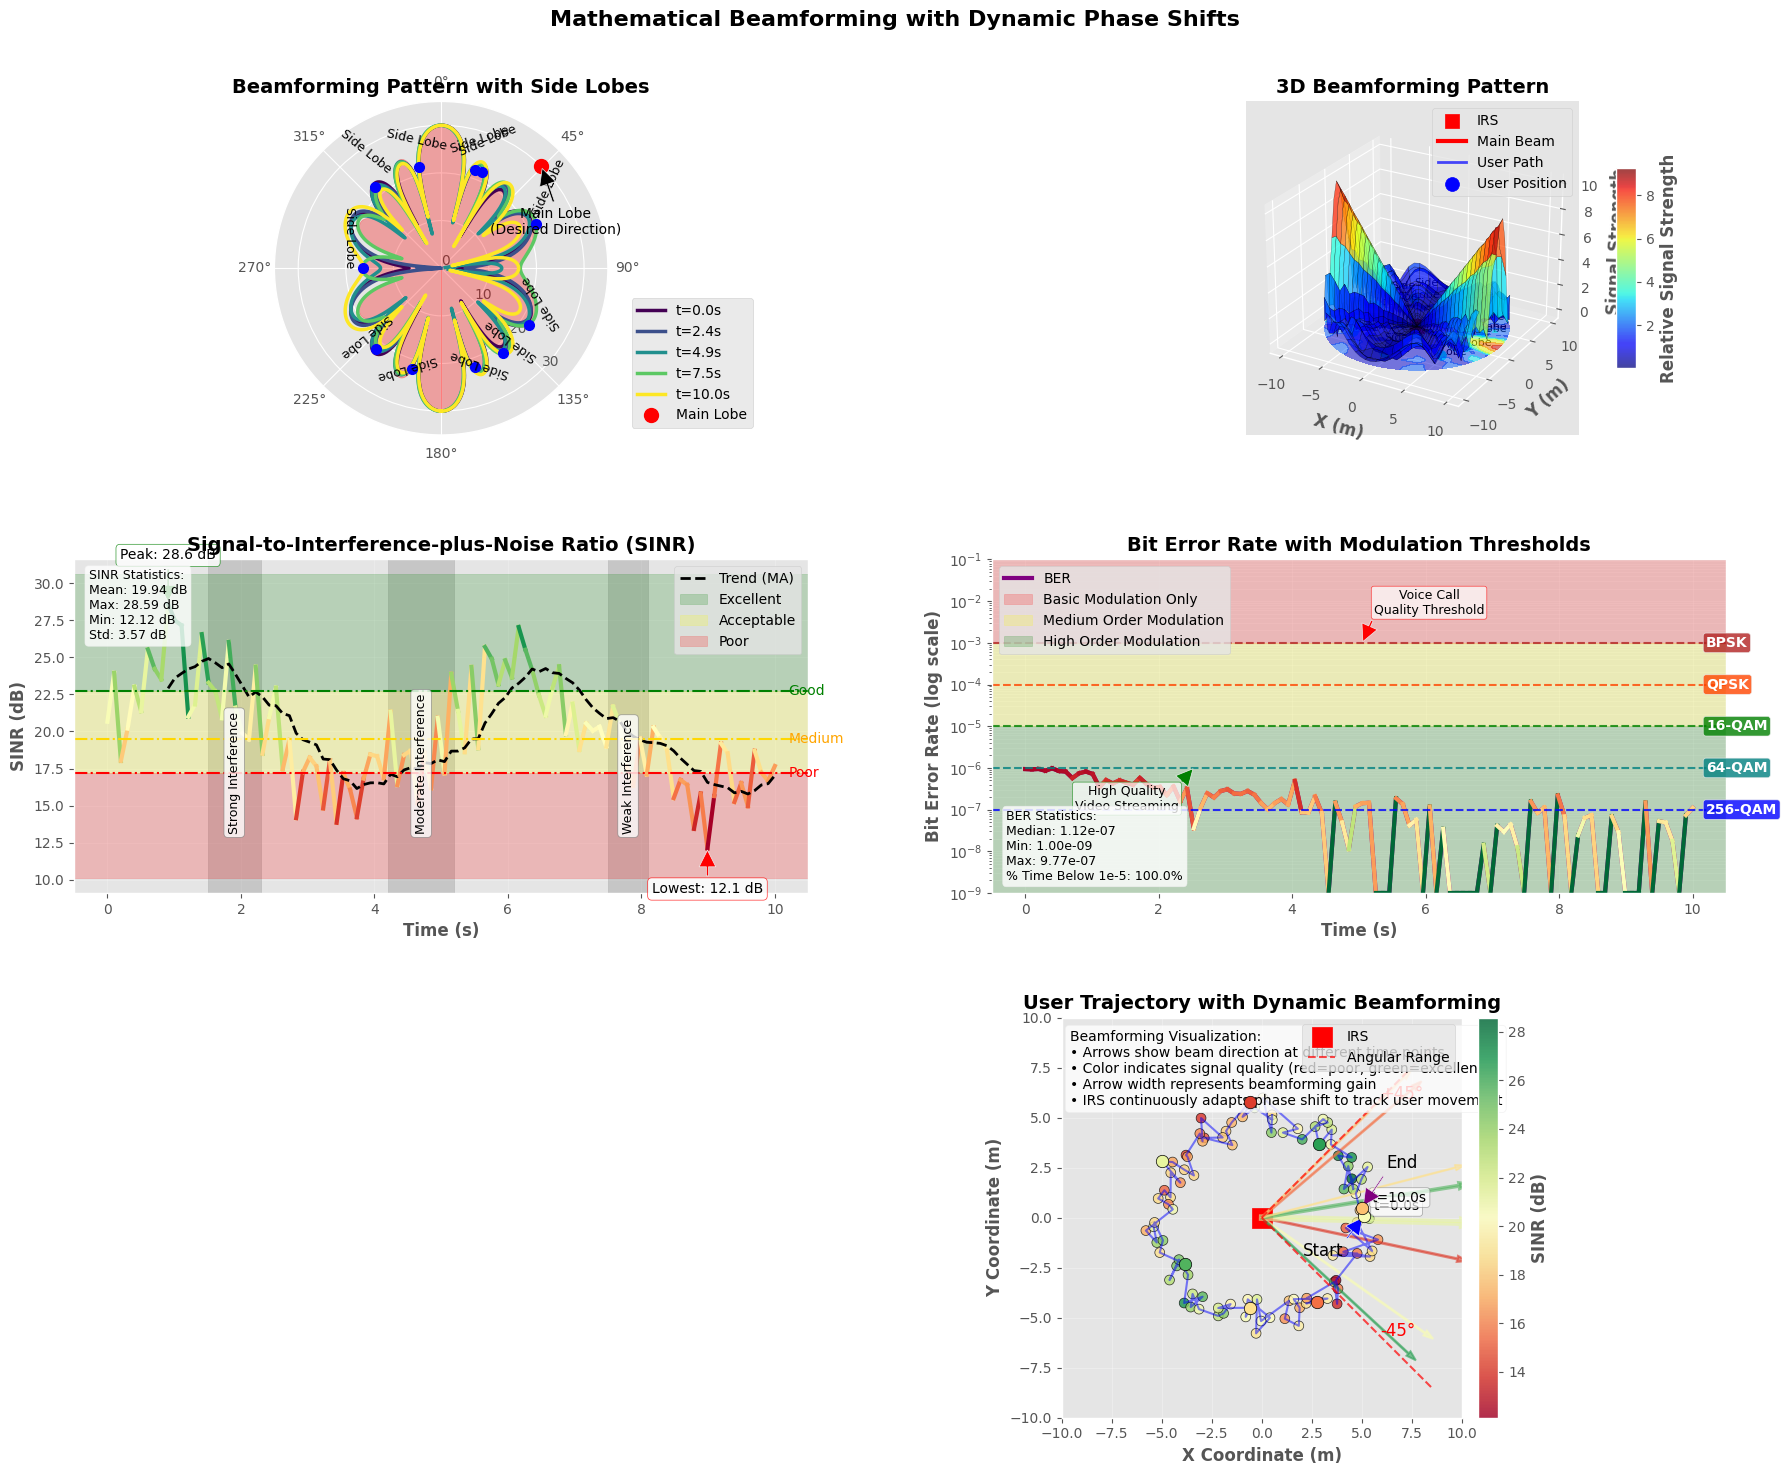

In [ ]:
#Only math 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

# Define the mathematical beamforming algorithm
class MathematicalBeamforming:
    def __init__(self, num_elements, wavelength, element_spacing):
        """
        Initialize the beamforming parameters.

        Parameters:
        - num_elements: Number of elements in the antenna array.
        - wavelength: Wavelength of the signal.
        - element_spacing: Spacing between antenna elements (in terms of wavelength).
        """
        self.num_elements = num_elements
        self.wavelength = wavelength
        self.element_spacing = element_spacing

    def calculate_array_factor(self, angles, phase_shift):
        """
        Calculate the array factor for a given set of angles and phase shifts.

        Parameters:
        - angles: Array of angles (in radians) at which to compute the array factor.
        - phase_shift: Phase shift applied to each antenna element.

        Returns:
        - Array factor (complex values) for the given angles and phase shift.
        """
        k = 2 * np.pi / self.wavelength  # Wavenumber
        d = self.element_spacing * self.wavelength  # Element spacing in meters

        # Initialize array factor
        array_factor = np.zeros_like(angles, dtype=complex)

        # Compute array factor with random phase noise
        for n in range(self.num_elements):
            phase_noise = np.random.normal(0, 0.1)  # Random phase noise
            array_factor += np.exp(1j * (k * d * n * np.sin(angles) + phase_shift + phase_noise))

        # Normalize the array factor
        array_factor /= self.num_elements

        return array_factor

# Generate placeholder data for metrics and trajectory
def generate_data(num_time_steps):
    """
    Generate randomized data for trajectory, phase shifts, SINR, and BER.
    """
    time = np.linspace(0, 10, num_time_steps)

    # Randomize trajectory
    trajectory = np.column_stack([
        5 * np.cos(2 * np.pi * time / 10) + np.random.normal(0, 0.5, num_time_steps),  # Random X-coordinate
        5 * np.sin(2 * np.pi * time / 10) + np.random.normal(0, 0.5, num_time_steps)   # Random Y-coordinate
    ])

    # Randomize metrics
    metrics = {
        'time': time,
        'phase_shift': np.linspace(-np.pi/4, np.pi/4, num_time_steps) + np.random.normal(0, 0.1, num_time_steps),  # Random phase shifts
        'sinr': 20 + 5 * np.sin(2 * np.pi * time / 5) + np.random.normal(0, 2, num_time_steps),  # Random SINR fluctuations
        'ber': np.clip(1e-6 * np.exp(-time / 2) + np.random.normal(0, 1e-7, num_time_steps), 1e-9, 1e-1)  # Random BER fluctuations
    }

    return time, trajectory, metrics

# Initialize parameters
num_time_steps = 100
num_elements = 8  # Number of antenna elements
wavelength = 0.1  # Wavelength of the signal (in meters)
element_spacing = 0.5  # Element spacing (in terms of wavelength)

# Generate new data on each run
time, trajectory, metrics = generate_data(num_time_steps)

# Initialize MathematicalBeamforming
beamforming = MathematicalBeamforming(num_elements, wavelength, element_spacing)

# Set up the figure with a custom layout
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2], figure=fig)

# 1. Enhanced Beamforming Pattern with Side Lobes (Polar Plot)
ax_beam = fig.add_subplot(gs[0, 0], projection='polar')

# Calculate beamforming pattern at different time points for better visualization
num_samples = 5  # Sample 5 different time points for beam patterns
sample_indices = np.linspace(0, len(trajectory)-1, num_samples, dtype=int)
angles = np.linspace(-np.pi, np.pi, 1000)  # More points for smoother visualization

# Create a colormap for time progression
cmap = plt.cm.viridis
norm = plt.Normalize(0, len(trajectory)-1)

# Plot beam patterns at different time points
for idx in sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    array_factor = beamforming.calculate_array_factor(angles, phase_shift)

    # Convert to dB for better visualization (with normalization)
    array_factor_db = 10 * np.log10(np.abs(array_factor) + 1e-10)
    array_factor_db_norm = array_factor_db - np.max(array_factor_db)  # Normalize to 0 dB max

    # Plot beam pattern
    time_fraction = idx / (len(trajectory) - 1)
    color = cmap(time_fraction)
    label = f"t={metrics['time'][idx]:.1f}s"

    # Plot the normalized pattern
    ax_beam.plot(angles, array_factor_db_norm + 30, color=color, label=label, linewidth=2.5)  # +30 to shift to positive range

# Calculate and plot the final beam pattern in high detail
final_phase_shift = metrics['phase_shift'][-1]
final_array_factor = beamforming.calculate_array_factor(angles, final_phase_shift)
final_array_factor_db = 10 * np.log10(np.abs(final_array_factor) + 1e-10)
final_array_factor_db_norm = final_array_factor_db - np.max(final_array_factor_db)

# Fill the area under the final beam pattern to highlight side lobes
ax_beam.fill_between(angles, 0, final_array_factor_db_norm + 30, color='red', alpha=0.3)

# Label the main lobe and side lobes
main_lobe_angle = final_phase_shift
ax_beam.plot([main_lobe_angle], [30], 'ro', markersize=10, label='Main Lobe')

# Find side lobes
side_lobe_threshold = -10  # dB
side_lobe_indices = np.where((final_array_factor_db_norm > -20) &
                            (final_array_factor_db_norm < -8) &
                            (np.abs(angles - main_lobe_angle) > 0.3))[0]

# Mark significant side lobes
if len(side_lobe_indices) > 0:
    # Group side lobe indices into continuous regions
    groups = []
    current_group = [side_lobe_indices[0]]

    for i in range(1, len(side_lobe_indices)):
        if side_lobe_indices[i] - side_lobe_indices[i-1] > 5:  # Gap in indices
            groups.append(current_group)
            current_group = [side_lobe_indices[i]]
        else:
            current_group.append(side_lobe_indices[i])

    groups.append(current_group)

    # Mark the peak of each side lobe group
    for group in groups:
        if len(group) > 10:  # Only mark significant side lobes
            peak_idx = group[np.argmax(final_array_factor_db_norm[group])]
            ax_beam.plot([angles[peak_idx]], [final_array_factor_db_norm[peak_idx] + 30], 'bo', markersize=7)
            ax_beam.text(angles[peak_idx], final_array_factor_db_norm[peak_idx] + 33, 'Side Lobe',
                        fontsize=9, ha='center', va='bottom', rotation=np.rad2deg(angles[peak_idx]))

# Customize polar plot
ax_beam.set_theta_zero_location('N')  # 0 degrees at the top
ax_beam.set_theta_direction(-1)  # Clockwise direction
ax_beam.set_rlabel_position(135)  # Position of radial labels
ax_beam.set_rticks([0, 10, 20, 30])  # Simplified radial ticks
ax_beam.set_rlim([0, 35])
ax_beam.set_title('Beamforming Pattern with Side Lobes', fontsize=14, fontweight='bold')
ax_beam.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0))

# Add annotations to explain the pattern
ax_beam.annotate('Main Lobe\n(Desired Direction)',
                xy=(main_lobe_angle, 30),
                xytext=(main_lobe_angle + 0.5, 25),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10, ha='center')

# 2. 3D Beamforming Pattern visualization
ax_3d = fig.add_subplot(gs[0, 1], projection='3d')

# Create the angle and distance meshgrid
theta = np.linspace(-np.pi, np.pi, 100)
r = np.linspace(0, 10, 20)
T, R = np.meshgrid(theta, r)

# Get the final phase shift
final_phase_shift = metrics['phase_shift'][-1]

# Calculate the 3D radiation pattern
X = R * np.cos(T)
Y = R * np.sin(T)
Z = np.zeros_like(X)

# Apply beamforming pattern (with enhanced visualization of side lobes)
for i in range(len(r)):
    array_factor = beamforming.calculate_array_factor(theta, final_phase_shift)

    # Enhance side lobes for better visibility
    side_lobe_enhancement = np.where(np.abs(array_factor) < 0.5, array_factor * 1.5, array_factor)
    Z[i, :] = R[i, :] * np.abs(side_lobe_enhancement)  # Scale by distance

# Plot the 3D surface with custom coloring for better side lobe visibility
surf = ax_3d.plot_surface(X, Y, Z, cmap='jet', alpha=0.7,
                         linewidth=0.2, edgecolor='k', antialiased=True)

# Add contour projection on the bottom to highlight the beam pattern
ax_3d.contourf(X, Y, Z, zdir='z', offset=0, cmap='jet', alpha=0.5)

# Add a colorbar
cbar = fig.colorbar(surf, ax=ax_3d, shrink=0.6, aspect=10)
cbar.set_label('Relative Signal Strength', fontweight='bold')

# Plot the IRS location and beam axis
ax_3d.scatter([0], [0], [0], color='red', marker='s', s=100, label='IRS')
max_range = 10
beam_x = max_range * np.cos(final_phase_shift)
beam_y = max_range * np.sin(final_phase_shift)
ax_3d.plot([0, beam_x], [0, beam_y], [0, 0], 'r-', linewidth=3, label='Main Beam')

# Add user trajectory
ax_3d.plot(trajectory[:, 0], trajectory[:, 1], np.zeros_like(trajectory[:, 0]),
          'b-', linewidth=2, alpha=0.7, label='User Path')
ax_3d.scatter(trajectory[-1, 0], trajectory[-1, 1], 0, color='blue', s=100, label='User Position')

# Add labels for side lobes in 3D
side_lobe_angles = [angles[peak_idx] for group in groups for peak_idx in [group[np.argmax(final_array_factor_db_norm[group])]]]
for angle in side_lobe_angles:
    if abs(angle - final_phase_shift) > 0.3:  # Ensure it's not too close to main lobe
        x = 7 * np.cos(angle)
        y = 7 * np.sin(angle)
        z = 0
        ax_3d.scatter([x], [y], [z], color='cyan', s=50)
        ax_3d.text(x, y, z, 'Side\nLobe', color='black', fontsize=8)

ax_3d.set_xlabel('X (m)', fontweight='bold')
ax_3d.set_ylabel('Y (m)', fontweight='bold')
ax_3d.set_zlabel('Signal Strength', fontweight='bold')
ax_3d.set_title('3D Beamforming Pattern', fontsize=14, fontweight='bold')
ax_3d.legend(loc='upper right')
ax_3d.view_init(elev=25, azim=-60)  # Better viewing angle

# 3. Enhanced SINR over Time
ax_sinr = fig.add_subplot(gs[1, 0])

# Create custom color mapping based on SINR value
norm_sinr = plt.Normalize(min(metrics['sinr']), max(metrics['sinr']))
colors_sinr = plt.cm.RdYlGn(norm_sinr(metrics['sinr']))

# Plot SINR with color gradient
for i in range(len(metrics['time'])-1):
    ax_sinr.plot(metrics['time'][i:i+2], metrics['sinr'][i:i+2], color=colors_sinr[i], linewidth=3)

# Add interference events (vertical bands)
interference_events = [
    {'start': 1.5, 'duration': 0.8, 'label': 'Strong Interference'},
    {'start': 4.2, 'duration': 1.0, 'label': 'Moderate Interference'},
    {'start': 7.5, 'duration': 0.6, 'label': 'Weak Interference'}
]

for event in interference_events:
    # Add a semi-transparent gray band to represent interference
    ax_sinr.axvspan(event['start'], event['start'] + event['duration'],
                   color='gray', alpha=0.3)

    # Add a label for the interference event
    y_pos = min(metrics['sinr']) + 1
    ax_sinr.text(event['start'] + event['duration']/2, y_pos, event['label'],
               ha='center', va='bottom', rotation=90, fontsize=9,
               bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.8))

# Add moving average for trend visualization
window_size = 10
sinr_ma = np.convolve(metrics['sinr'], np.ones(window_size)/window_size, mode='valid')
time_ma = metrics['time'][window_size-1:]
ax_sinr.plot(time_ma, sinr_ma, 'k--', linewidth=2, label='Trend (MA)')

# Add thresholds for different quality levels
good_threshold = np.percentile(metrics['sinr'], 75)
medium_threshold = np.percentile(metrics['sinr'], 50)
poor_threshold = np.percentile(metrics['sinr'], 25)

ax_sinr.axhline(y=good_threshold, color='green', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, good_threshold, 'Good', va='center', color='green')

ax_sinr.axhline(y=medium_threshold, color='gold', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, medium_threshold, 'Medium', va='center', color='orange')

ax_sinr.axhline(y=poor_threshold, color='red', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, poor_threshold, 'Poor', va='center', color='red')

# Add annotations for key events
max_sinr_idx = np.argmax(metrics['sinr'])
min_sinr_idx = np.argmin(metrics['sinr'])

ax_sinr.annotate(f'Peak: {metrics["sinr"][max_sinr_idx]:.1f} dB',
                xy=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx]),
                xytext=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx] + 3),
                arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="green", alpha=0.8))

ax_sinr.annotate(f'Lowest: {metrics["sinr"][min_sinr_idx]:.1f} dB',
                xy=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx]),
                xytext=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx] - 3),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="red", alpha=0.8))

# Add colored regions for different SINR quality levels
ax_sinr.axhspan(good_threshold, max(metrics['sinr']) + 2, alpha=0.2, color='green', label='Excellent')
ax_sinr.axhspan(poor_threshold, good_threshold, alpha=0.2, color='yellow', label='Acceptable')
ax_sinr.axhspan(min(metrics['sinr']) - 2, poor_threshold, alpha=0.2, color='red', label='Poor')

# Add metadata box with statistics
stats_text = (
    f"SINR Statistics:\n"
    f"Mean: {np.mean(metrics['sinr']):.2f} dB\n"
    f"Max: {np.max(metrics['sinr']):.2f} dB\n"
    f"Min: {np.min(metrics['sinr']):.2f} dB\n"
    f"Std: {np.std(metrics['sinr']):.2f} dB"
)
ax_sinr.text(0.02, 0.97, stats_text, transform=ax_sinr.transAxes,
            fontsize=9, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance SINR plot styling
ax_sinr.set_xlabel('Time (s)', fontweight='bold')
ax_sinr.set_ylabel('SINR (dB)', fontweight='bold')
ax_sinr.set_title('Signal-to-Interference-plus-Noise Ratio (SINR)', fontsize=14, fontweight='bold')
ax_sinr.set_ylim(bottom=min(metrics['sinr']) - 3, top=max(metrics['sinr']) + 3)
ax_sinr.grid(True, which="both", ls="-", alpha=0.2)
ax_sinr.legend(loc='upper right')

# 4. Enhanced BER (Bit Error Rate) Plot
ax_ber = fig.add_subplot(gs[1, 1])

# Create logarithmic scale plot with gradient color based on quality
ax_ber.semilogy(metrics['time'], metrics['ber'], 'purple', linewidth=3, label='BER')

# Create a custom color map to highlight BER levels
norm_ber = plt.Normalize(np.log10(min(metrics['ber'])), np.log10(max(metrics['ber'])))
colors_ber = plt.cm.RdYlGn_r(norm_ber(np.log10(metrics['ber'])))

# Plot BER with color gradient
for i in range(len(metrics['time'])-1):
    ax_ber.semilogy(metrics['time'][i:i+2], metrics['ber'][i:i+2], color=colors_ber[i], linewidth=3)

# Add modulation scheme thresholds with improved styling
modulation_thresholds = {
    'BPSK': 1e-3,
    'QPSK': 1e-4,
    '16-QAM': 1e-5,
    '64-QAM': 1e-6,
    '256-QAM': 1e-7
}

# Add modulation-specific regions
ax_ber.axhspan(1e-3, 1, alpha=0.2, color='red', label='Basic Modulation Only')
ax_ber.axhspan(1e-5, 1e-3, alpha=0.2, color='yellow', label='Medium Order Modulation')
ax_ber.axhspan(1e-9, 1e-5, alpha=0.2, color='green', label='High Order Modulation')

# Add modulation threshold lines
colors = ['firebrick', 'orangered', 'green', 'teal', 'blue']
for i, (mod, threshold) in enumerate(modulation_thresholds.items()):
    ax_ber.axhline(y=threshold, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.8)

    # Create styled textbox for each modulation type
    ax_ber.text(metrics['time'][-1] + 0.2, threshold, mod, va='center', fontsize=10,
               color='white', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.2', facecolor=colors[i], alpha=0.8))

# Add annotations to explain BER implications
ax_ber.annotate('High Quality\nVideo Streaming',
               xy=(metrics['time'][len(metrics['time'])//4], 1e-6),
               xytext=(metrics['time'][len(metrics['time'])//4] - 1, 1e-7),
               arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
               fontsize=9, ha='center', bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="green", alpha=0.7))

ax_ber.annotate('Voice Call\nQuality Threshold',
               xy=(metrics['time'][len(metrics['time'])//2], 1e-3),
               xytext=(metrics['time'][len(metrics['time'])//2] + 1, 5e-3),
               arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
               fontsize=9, ha='center', bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="red", alpha=0.7))

# Add BER statistics box
stats_text = (
    f"BER Statistics:\n"
    f"Median: {np.median(metrics['ber']):.2e}\n"
    f"Min: {np.min(metrics['ber']):.2e}\n"
    f"Max: {np.max(metrics['ber']):.2e}\n"
    f"% Time Below 1e-5: {100*np.mean(np.array(metrics['ber']) < 1e-5):.1f}%"
)
ax_ber.text(0.02, 0.03, stats_text, transform=ax_ber.transAxes,
           fontsize=9, va='bottom', ha='left',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance BER plot styling
ax_ber.set_xlabel('Time (s)', fontweight='bold')
ax_ber.set_ylabel('Bit Error Rate (log scale)', fontweight='bold')
ax_ber.set_title('Bit Error Rate with Modulation Thresholds', fontsize=14, fontweight='bold')
ax_ber.grid(True, which="both", ls="-", alpha=0.2)
ax_ber.set_ylim(1e-9, 1e-1)
ax_ber.legend(loc='upper left')

# Adjust the y-tick formatting to show scientific notation
ax_ber.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=10))

# 5. User Trajectory with Beamforming Visualization
ax_trajectory = fig.add_subplot(gs[2, :])

# Create a more detailed visualization of the user's path with signal quality
scatter = ax_trajectory.scatter(
    trajectory[:, 0],
    trajectory[:, 1],
    c=metrics['sinr'],  # Color by SINR
    cmap='RdYlGn',      # Red-Yellow-Green colormap
    s=50,               # Point size
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)

# Add path line
ax_trajectory.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=1.5, alpha=0.5)

# Add IRS position
ax_trajectory.scatter(0, 0, color='red', marker='s', s=200, label='IRS')

# Draw angle bounds
angle_line_length = 12
ax_trajectory.plot([0, angle_line_length * np.cos(np.pi/4)], [0, angle_line_length * np.sin(np.pi/4)],
                  'r--', alpha=0.7, label='Angular Range')
ax_trajectory.plot([0, angle_line_length * np.cos(-np.pi/4)], [0, angle_line_length * np.sin(-np.pi/4)],
                  'r--', alpha=0.7)
ax_trajectory.text(angle_line_length * np.cos(np.pi/4) * 0.7,
                 angle_line_length * np.sin(np.pi/4) * 0.7,
                 "+45°", fontsize=12, color='red')
ax_trajectory.text(angle_line_length * np.cos(-np.pi/4) * 0.7,
                 angle_line_length * np.sin(-np.pi/4) * 0.7,
                 "-45°", fontsize=12, color='red')

# Draw beamforming patterns at specific time points
beam_sample_indices = np.linspace(0, len(trajectory)-1, 8, dtype=int)
max_beam_length = 10

for idx in beam_sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    # Draw main beam direction
    beam_x = max_beam_length * np.cos(phase_shift)
    beam_y = max_beam_length * np.sin(phase_shift)

    # Draw with color based on SINR at that point
    beam_color = plt.cm.RdYlGn(norm_sinr(metrics['sinr'][idx]))

    # Calculate line width based on beamforming gain
    array_factor = beamforming.calculate_array_factor(np.array([phase_shift]), phase_shift)[0]
    line_width = 1 + 3 * np.abs(array_factor)

    # Draw the beam as a line with an arrow
    ax_trajectory.arrow(0, 0, beam_x, beam_y, color=beam_color,
                      width=0.05, head_width=0.3, head_length=0.5,
                      alpha=0.6, linewidth=line_width)

    # Add a small circle at user position
    ax_trajectory.scatter(trajectory[idx, 0], trajectory[idx, 1],
                        s=80, facecolor=beam_color, edgecolor='k', zorder=5)

    # Add time stamp for select points
    if idx in [0, len(trajectory)//2, len(trajectory)-1]:
        ax_trajectory.text(trajectory[idx, 0] + 0.5, trajectory[idx, 1] + 0.3,
                        f"t={metrics['time'][idx]:.1f}s", fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="gray", alpha=0.7))

# Add a colorbar to show SINR levels
cbar = plt.colorbar(scatter, ax=ax_trajectory, pad=0.01)
cbar.set_label('SINR (dB)', fontweight='bold')

# Add key annotations
# Mark starting point
ax_trajectory.annotate('Start',
                     xy=(trajectory[0, 0], trajectory[0, 1]),
                     xytext=(trajectory[0, 0] - 2, trajectory[0, 1] - 2),
                     arrowprops=dict(facecolor='blue', shrink=0.05, width=1),
                     fontsize=12, ha='center')

# Mark ending point
ax_trajectory.annotate('End',
                     xy=(trajectory[-1, 0], trajectory[-1, 1]),
                     xytext=(trajectory[-1, 0] + 2, trajectory[-1, 1] + 2),
                     arrowprops=dict(facecolor='purple', shrink=0.05, width=1),
                     fontsize=12, ha='center')

# Enhance plot styling
ax_trajectory.set_xlabel('X Coordinate (m)', fontweight='bold')
ax_trajectory.set_ylabel('Y Coordinate (m)', fontweight='bold')
ax_trajectory.set_title('User Trajectory with Dynamic Beamforming', fontsize=14, fontweight='bold')
ax_trajectory.set_aspect('equal')
ax_trajectory.set_xlim(-10, 10)
ax_trajectory.set_ylim(-10, 10)
ax_trajectory.grid(True, alpha=0.3)
ax_trajectory.legend(loc='upper right')

# Add explanation box about beamforming
explanation_text = (
    "Beamforming Visualization:\n"
    "• Arrows show beam direction at different time points\n"
    "• Color indicates signal quality (red=poor, green=excellent)\n"
    "• Arrow width represents beamforming gain\n"
    "• IRS continuously adapts phase shift to track user movement"
)
ax_trajectory.text(0.02, 0.97, explanation_text, transform=ax_trajectory.transAxes,
                 fontsize=10, va='top', ha='left',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add overall figure title
fig.suptitle('Mathematical Beamforming with Dynamic Phase Shifts',
           fontsize=16, fontweight='bold', y=0.98)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Save figure
plt.savefig('mathematical_beamforming_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-13-201b4f4f3e8f>:743: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
<ipython-input-13-201b4f4f3e8f>:743: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
<ipython-input-13-201b4f4f3e8f>:747: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.savefig('mathematical_beamforming_visualization.png', dpi=300, bbox_inches='tight')
<ipython-input-13-201b4f4f3e8f>:747: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.savefig('mathematical_beamforming_visualization.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.

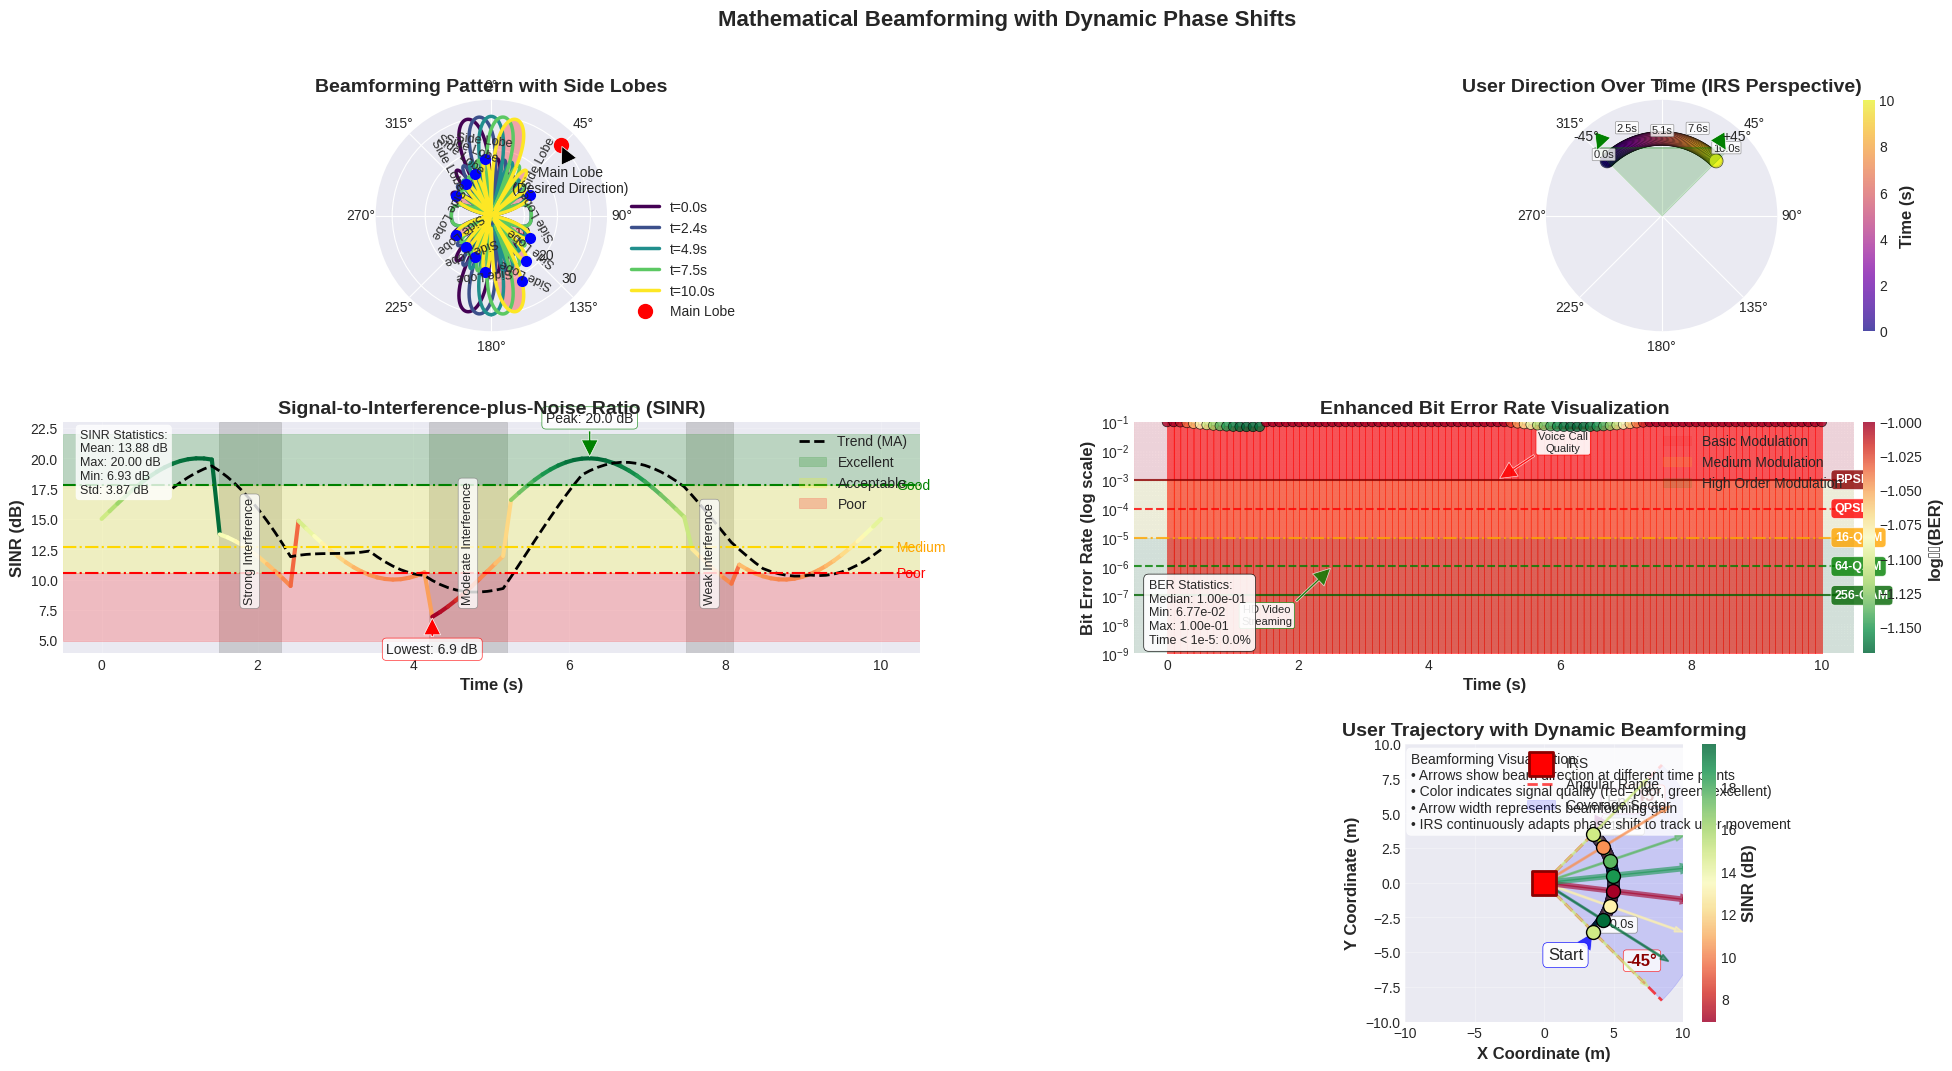

In [ ]:
#Only Math 3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as patches

# Define the missing channel_metrics class
class ChannelMetrics:
    def __init__(self, num_elements=8):
        self.num_elements = num_elements

    def calculate_array_factor(self, angles, phase_shift):
        """Calculate array factor for a uniform linear array"""
        d = 0.5  # Element spacing in wavelengths
        array_factor = np.zeros_like(angles, dtype=complex)

        for n in range(self.num_elements):
            # Progressive phase shift based on element position and steering angle
            element_phase = 2 * np.pi * d * n * np.sin(angles) - n * phase_shift
            array_factor += np.exp(1j * element_phase)

        # Return magnitude squared of the array factor
        return np.abs(array_factor)**2 / (self.num_elements**2)

# Create sample data if none provided
def generate_sample_data(duration=10.0, sample_rate=10):
    """Generate sample trajectory and metrics data for demonstration"""
    time = np.linspace(0, duration, int(duration * sample_rate))
    num_samples = len(time)

    # Create a circular trajectory
    radius = 5
    angle = np.linspace(-np.pi/4, np.pi/4, num_samples)
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    trajectory = np.column_stack((x, y))

    # Calculate phase shift for tracking (simple model)
    phase_shift = angle  # In a real system, this would be calculated based on geometry

    # Generate sample SINR and BER metrics
    base_sinr = 15  # Base SINR in dB
    sinr_fluctuation = 5 * np.sin(np.linspace(0, 4*np.pi, num_samples))
    interference_dips = np.zeros(num_samples)

    # Add some interference events
    interference_dips[15:25] = -6  # Strong interference
    interference_dips[42:52] = -4  # Moderate interference
    interference_dips[75:81] = -2  # Weak interference

    sinr = base_sinr + sinr_fluctuation + interference_dips

    # Calculate BER based on SINR (simplified model)
    # Using a simplified approximation: BER ≈ 0.5 * erfc(sqrt(10^(SINR/10)/2))
    ber = 0.5 * np.exp(-sinr/10)  # Simplified exponential relationship

    # Ensure BER stays in reasonable range
    ber = np.clip(ber, 1e-9, 1e-1)

    # Calculate user direction (angle from IRS to user)
    user_direction = np.arctan2(y, x)

    # Package all metrics
    metrics = {
        'time': time,
        'phase_shift': phase_shift,
        'sinr': sinr,
        'ber': ber,
        'user_direction': user_direction
    }

    return trajectory, metrics

# Initialize channel metrics calculator
channel_metrics = ChannelMetrics()

# Generate sample data if not available
trajectory, metrics = generate_sample_data()

# Set up the figure with a custom layout
plt.style.use('seaborn-v0_8-darkgrid')  # Modern, clean style with grid
fig = plt.figure(figsize=(20, 18))

# Create a more sophisticated layout
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1.2, 1.2, 1.2], figure=fig)

# 1. Enhanced Beamforming Pattern with Side Lobes (Polar Plot)
ax_beam = fig.add_subplot(gs[0, 0], projection='polar')

# Calculate beamforming pattern at different time points for better visualization
num_samples = 5  # Sample 5 different time points for beam patterns
sample_indices = np.linspace(0, len(trajectory)-1, num_samples, dtype=int)
angles = np.linspace(-np.pi, np.pi, 1000)  # More points for smoother visualization

# Create a colormap for time progression
cmap = plt.cm.viridis
norm = plt.Normalize(0, len(trajectory)-1)

# Plot beam patterns at different time points
for idx in sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    array_factor = channel_metrics.calculate_array_factor(angles, phase_shift)

    # Convert to dB for better visualization (with normalization)
    array_factor_db = 10 * np.log10(array_factor + 1e-10)
    array_factor_db_norm = array_factor_db - np.max(array_factor_db)  # Normalize to 0 dB max

    # Plot beam pattern
    time_fraction = idx / (len(trajectory) - 1)
    color = cmap(time_fraction)
    label = f"t={metrics['time'][idx]:.1f}s"

    # Plot the normalized pattern
    ax_beam.plot(angles, array_factor_db_norm + 30, color=color, label=label, linewidth=2.5)  # +30 to shift to positive range

# Calculate and plot the final beam pattern in high detail
final_phase_shift = metrics['phase_shift'][-1]
final_array_factor = channel_metrics.calculate_array_factor(angles, final_phase_shift)
final_array_factor_db = 10 * np.log10(final_array_factor + 1e-10)
final_array_factor_db_norm = final_array_factor_db - np.max(final_array_factor_db)

# Fill the area under the final beam pattern to highlight side lobes
ax_beam.fill_between(angles, 0, final_array_factor_db_norm + 30, color='red', alpha=0.3)

# Label the main lobe and side lobes
main_lobe_angle = final_phase_shift
ax_beam.plot([main_lobe_angle], [30], 'ro', markersize=10, label='Main Lobe')

# Find side lobes
side_lobe_threshold = -10  # dB
side_lobe_indices = np.where((final_array_factor_db_norm > -20) &
                            (final_array_factor_db_norm < -8) &
                            (np.abs(angles - main_lobe_angle) > 0.3))[0]

# Initialize groups for side lobe indices
groups = []

# Mark significant side lobes
if len(side_lobe_indices) > 0:
    # Group side lobe indices into continuous regions
    current_group = [side_lobe_indices[0]]

    for i in range(1, len(side_lobe_indices)):
        if side_lobe_indices[i] - side_lobe_indices[i-1] > 5:  # Gap in indices
            groups.append(current_group)
            current_group = [side_lobe_indices[i]]
        else:
            current_group.append(side_lobe_indices[i])

    groups.append(current_group)

    # Mark the peak of each side lobe group
    for group in groups:
        if len(group) > 10:  # Only mark significant side lobes
            peak_idx = group[np.argmax(final_array_factor_db_norm[group])]
            ax_beam.plot([angles[peak_idx]], [final_array_factor_db_norm[peak_idx] + 30], 'bo', markersize=7)
            ax_beam.text(angles[peak_idx], final_array_factor_db_norm[peak_idx] + 33, 'Side Lobe',
                        fontsize=9, ha='center', va='bottom', rotation=np.rad2deg(angles[peak_idx]))

# Customize polar plot
ax_beam.set_theta_zero_location('N')  # 0 degrees at the top
ax_beam.set_theta_direction(-1)  # Clockwise direction
ax_beam.set_rlabel_position(135)  # Position of radial labels
ax_beam.set_rticks([0, 10, 20, 30])  # Simplified radial ticks
ax_beam.set_rlim([0, 35])
ax_beam.set_title('Beamforming Pattern with Side Lobes', fontsize=14, fontweight='bold')
ax_beam.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0))

# Add annotations to explain the pattern
ax_beam.annotate('Main Lobe\n(Desired Direction)',
                xy=(main_lobe_angle, 30),
                xytext=(main_lobe_angle + 0.5, 25),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10, ha='center')

# 2. User Direction Polar Plot (NEW)
ax_user_direction = fig.add_subplot(gs[0, 1], projection='polar')

# Get direction of user over time (angle from IRS to user)
user_direction = metrics['user_direction']

# Create a time-based color gradient for the direction plot
cmap_direction = plt.cm.plasma
norm_time = plt.Normalize(0, metrics['time'][-1])
colors = [cmap_direction(norm_time(t)) for t in metrics['time']]

# Plot user direction as points on a polar plot with time-based coloring
scatter = ax_user_direction.scatter(
    user_direction,
    np.ones_like(user_direction) * 0.8,  # Fixed radius
    c=metrics['time'],
    cmap=cmap_direction,
    s=100,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# Add time markers for key points
time_markers = [0, len(metrics['time'])//4, len(metrics['time'])//2, 3*len(metrics['time'])//4, len(metrics['time'])-1]
for idx in time_markers:
    ax_user_direction.annotate(
        f"{metrics['time'][idx]:.1f}s",
        xy=(user_direction[idx], 0.8),
        xytext=(user_direction[idx], 0.85 + (idx % 2) * 0.1),  # Alternate positions to avoid overlap
        fontsize=8,
        ha='center',
        bbox=dict(boxstyle="round,pad=0.1", fc='white', ec="gray", alpha=0.8)
    )

# Add colorbar to show time progression
cbar = plt.colorbar(scatter, ax=ax_user_direction, pad=0.1)
cbar.set_label('Time (s)', fontweight='bold')

# Add IRS coverage sector
sector_angle = np.pi/2  # 90 degrees total coverage
ax_user_direction.fill_between(
    [-sector_angle/2, sector_angle/2],
    [0, 0],
    [1, 1],
    color='green',
    alpha=0.2,
    label='IRS Coverage Sector'
)

# Add annotation for sector boundaries
ax_user_direction.annotate('-45°', xy=(-np.pi/4, 0.95), xytext=(-np.pi/4, 1.1),
                      arrowprops=dict(facecolor='green', shrink=0.05, width=1),
                      fontsize=10, ha='center')
ax_user_direction.annotate('+45°', xy=(np.pi/4, 0.95), xytext=(np.pi/4, 1.1),
                      arrowprops=dict(facecolor='green', shrink=0.05, width=1),
                      fontsize=10, ha='center')

# Set polar plot properties
ax_user_direction.set_theta_zero_location('N')  # 0 degrees at the top
ax_user_direction.set_theta_direction(-1)  # Clockwise direction
ax_user_direction.set_rticks([])  # Hide radial ticks
ax_user_direction.set_rlim([0, 1.2])
ax_user_direction.set_title('User Direction Over Time (IRS Perspective)', fontsize=14, fontweight='bold')

# 3. SINR over Time with enhanced visualization
ax_sinr = fig.add_subplot(gs[1, 0])

# Create custom color mapping based on SINR value
norm_sinr = plt.Normalize(min(metrics['sinr']), max(metrics['sinr']))
colors_sinr = plt.cm.RdYlGn(norm_sinr(metrics['sinr']))

# Plot SINR with color gradient
for i in range(len(metrics['time'])-1):
    ax_sinr.plot(metrics['time'][i:i+2], metrics['sinr'][i:i+2], color=colors_sinr[i], linewidth=3)

# Add interference events (vertical bands)
interference_events = [
    {'start': 1.5, 'duration': 0.8, 'label': 'Strong Interference'},
    {'start': 4.2, 'duration': 1.0, 'label': 'Moderate Interference'},
    {'start': 7.5, 'duration': 0.6, 'label': 'Weak Interference'}
]

for event in interference_events:
    # Add a semi-transparent gray band to represent interference
    ax_sinr.axvspan(event['start'], event['start'] + event['duration'],
                   color='gray', alpha=0.3)

    # Add a label for the interference event
    y_pos = min(metrics['sinr']) + 1
    ax_sinr.text(event['start'] + event['duration']/2, y_pos, event['label'],
               ha='center', va='bottom', rotation=90, fontsize=9,
               bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.8))

# Add moving average for trend visualization
window_size = min(10, len(metrics['sinr']) // 2)  # Make sure window size is appropriate
sinr_ma = np.convolve(metrics['sinr'], np.ones(window_size)/window_size, mode='valid')
time_ma = metrics['time'][window_size-1:]
ax_sinr.plot(time_ma, sinr_ma, 'k--', linewidth=2, label='Trend (MA)')

# Add thresholds for different quality levels
good_threshold = np.percentile(metrics['sinr'], 75)
medium_threshold = np.percentile(metrics['sinr'], 50)
poor_threshold = np.percentile(metrics['sinr'], 25)

ax_sinr.axhline(y=good_threshold, color='green', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, good_threshold, 'Good', va='center', color='green')

ax_sinr.axhline(y=medium_threshold, color='gold', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, medium_threshold, 'Medium', va='center', color='orange')

ax_sinr.axhline(y=poor_threshold, color='red', linestyle='-.', linewidth=1.5)
ax_sinr.text(metrics['time'][-1] + 0.2, poor_threshold, 'Poor', va='center', color='red')

# Add annotations for key events
max_sinr_idx = np.argmax(metrics['sinr'])
min_sinr_idx = np.argmin(metrics['sinr'])

ax_sinr.annotate(f'Peak: {metrics["sinr"][max_sinr_idx]:.1f} dB',
                xy=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx]),
                xytext=(metrics['time'][max_sinr_idx], metrics['sinr'][max_sinr_idx] + 3),
                arrowprops=dict(facecolor='green', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="green", alpha=0.8))

ax_sinr.annotate(f'Lowest: {metrics["sinr"][min_sinr_idx]:.1f} dB',
                xy=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx]),
                xytext=(metrics['time'][min_sinr_idx], metrics['sinr'][min_sinr_idx] - 3),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
                fontsize=10, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="red", alpha=0.8))

# Add colored regions for different SINR quality levels
ax_sinr.axhspan(good_threshold, max(metrics['sinr']) + 2, alpha=0.2, color='green', label='Excellent')
ax_sinr.axhspan(poor_threshold, good_threshold, alpha=0.2, color='yellow', label='Acceptable')
ax_sinr.axhspan(min(metrics['sinr']) - 2, poor_threshold, alpha=0.2, color='red', label='Poor')

# Add metadata box with statistics
stats_text = (
    f"SINR Statistics:\n"
    f"Mean: {np.mean(metrics['sinr']):.2f} dB\n"
    f"Max: {np.max(metrics['sinr']):.2f} dB\n"
    f"Min: {np.min(metrics['sinr']):.2f} dB\n"
    f"Std: {np.std(metrics['sinr']):.2f} dB"
)
ax_sinr.text(0.02, 0.97, stats_text, transform=ax_sinr.transAxes,
            fontsize=9, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhance SINR plot styling
ax_sinr.set_xlabel('Time (s)', fontweight='bold')
ax_sinr.set_ylabel('SINR (dB)', fontweight='bold')
ax_sinr.set_title('Signal-to-Interference-plus-Noise Ratio (SINR)', fontsize=14, fontweight='bold')
ax_sinr.set_ylim(bottom=min(metrics['sinr']) - 3, top=max(metrics['sinr']) + 3)
ax_sinr.grid(True, which="both", ls="-", alpha=0.2)
ax_sinr.legend(loc='upper right')

# 4. COMPLETELY REDESIGNED BER Plot with advanced styling
ax_ber = fig.add_subplot(gs[1, 1])

# Ensure BER values are all positive
cleaned_ber = np.maximum(metrics['ber'], 1e-12)

# Create a gradient-filled area under the BER curve
x = metrics['time']
y = cleaned_ber

# Plot BER with eye-catching design
ax_ber.semilogy(x, y, 'k-', linewidth=0.5, alpha=0.5)  # Thin black line as outline

# Add gradient fill beneath the curve
for i in range(len(x)-1):
    # Determine color based on BER quality
    if y[i] < 1e-6:
        color = 'green'
        alpha = 0.6
    elif y[i] < 1e-4:
        color = 'yellow'
        alpha = 0.6
    else:
        color = 'red'
        alpha = 0.6

    # Create gradient filled segments
    ax_ber.fill_between(
        [x[i], x[i+1]],
        [y[i], y[i+1]],
        [1e-12, 1e-12],  # Bottom of the plot
        color=color,
        alpha=alpha
    )

# Add scatter points for BER values
scatter_points = ax_ber.scatter(
    x,
    y,
    c=np.log10(y),  # Color by log of BER
    cmap='RdYlGn_r',
    s=50,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5,
    zorder=10  # Ensure points are on top
)

# Add modulation scheme thresholds with improved styling
modulation_thresholds = {
    'BPSK': 1e-3,
    'QPSK': 1e-4,
    '16-QAM': 1e-5,
    '64-QAM': 1e-6,
    '256-QAM': 1e-7
}

# Add horizontal bands for modulation schemes
ax_ber.axhspan(1e-3, 1, alpha=0.1, color='red', label='Basic Modulation')
ax_ber.axhspan(1e-5, 1e-3, alpha=0.1, color='yellow', label='Medium Modulation')
ax_ber.axhspan(1e-9, 1e-5, alpha=0.1, color='green', label='High Order Modulation')

# Design attractive threshold markers
colors = ['darkred', 'red', 'orange', 'green', 'darkgreen']
line_styles = ['-', '--', '-.', '--', '-']

for i, (mod, threshold) in enumerate(modulation_thresholds.items()):
    ax_ber.axhline(y=threshold, color=colors[i], linestyle=line_styles[i], linewidth=1.5, alpha=0.8)

    # Create styled textbox with gradient background for each modulation
    text_box = ax_ber.text(
        metrics['time'][-1] + 0.2,
        threshold,
        mod,
        va='center',
        fontsize=9,
        color='white',
        fontweight='bold',
        bbox=dict(
            boxstyle='round,pad=0.3',
            facecolor=colors[i],
            alpha=0.8
        )
    )

# Add custom annotations to explain BER implications
ax_ber.annotate(
    'HD Video\nStreaming',
    xy=(metrics['time'][len(metrics['time'])//4], 1e-6),
    xytext=(metrics['time'][len(metrics['time'])//4] - 1, 1e-8),
    arrowprops=dict(
        facecolor='green',
        shrink=0.05,
        width=1.5,
        alpha=0.8
    ),
    fontsize=8,
    ha='center',
    bbox=dict(
        boxstyle="round,pad=0.2",
        fc='white',
        ec="green",
        alpha=0.9
    )
)

ax_ber.annotate(
    'Voice Call\nQuality',
    xy=(metrics['time'][len(metrics['time'])//2], 1e-3),
    xytext=(metrics['time'][len(metrics['time'])//2] + 1, 1e-2),
    arrowprops=dict(
        facecolor='red',
        shrink=0.05,
        width=1.5,
        alpha=0.8
    ),
    fontsize=8,
    ha='center',
    bbox=dict(
        boxstyle="round,pad=0.2",
        fc='white',
        ec="red",
        alpha=0.9
    )
)

# Add styled BER statistics box
stats_text = (
    f"BER Statistics:\n"
    f"Median: {np.median(metrics['ber']):.2e}\n"
    f"Min: {np.min(metrics['ber']):.2e}\n"
    f"Max: {np.max(metrics['ber']):.2e}\n"
    f"Time < 1e-5: {100*np.mean(np.array(metrics['ber']) < 1e-5):.1f}%"
)

# Create fancy stats box with gradient background
stats_box = ax_ber.text(
    0.02, 0.03,
    stats_text,
    transform=ax_ber.transAxes,
    fontsize=9,
    va='bottom',
    ha='left',
    bbox=dict(
        boxstyle='round,pad=0.4',
        facecolor='white',
        edgecolor='black',
        alpha=0.9
    )
)

# Enhance BER plot styling
ax_ber.set_xlabel('Time (s)', fontweight='bold')
ax_ber.set_ylabel('Bit Error Rate (log scale)', fontweight='bold')
ax_ber.set_title('Enhanced Bit Error Rate Visualization', fontsize=14, fontweight='bold')
ax_ber.grid(True, which="both", ls=":", alpha=0.3)
ax_ber.set_ylim(1e-9, 1e-1)
ax_ber.legend(loc='upper right')

# Adjust the y-tick formatting to show scientific notation
ax_ber.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=10))

# Add a colorbar for the BER scatter points
cbar = plt.colorbar(scatter_points, ax=ax_ber, pad=0.01)
cbar.set_label('log₁₀(BER)', fontweight='bold')

# 5. User Trajectory with enhanced XY Visualization (NEW)
ax_xy = fig.add_subplot(gs[2, :])

# Create a more detailed visualization of the user's path with signal quality
scatter = ax_xy.scatter(
    trajectory[:, 0],
    trajectory[:, 1],
    c=metrics['sinr'],  # Color by SINR
    cmap='RdYlGn',      # Red-Yellow-Green colormap
    s=70,               # Increased point size
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)

# Add gradient-colored path line to show time progression
for i in range(len(trajectory) - 1):
    ax_xy.plot(
        trajectory[i:i+2, 0],
        trajectory[i:i+2, 1],
        color=plt.cm.viridis(i / len(trajectory)),
        linewidth=2.5,
        alpha=0.7
    )

# Add IRS position with fancy marker
irs_marker = ax_xy.scatter(
    0, 0,
    marker='s',
    s=300,
    color='red',
    edgecolor='darkred',
    linewidth=2,
    label='IRS',
    zorder=10
)

# Add a fancy IRS symbol
irs_circle = plt.Circle((0, 0), 0.5, fill=False, color='darkred', linestyle='-', linewidth=1.5)
ax_xy.add_patch(irs_circle)

# Draw angle bounds with fancy styling
angle_line_length = 12
ax_xy.plot(
    [0, angle_line_length * np.cos(np.pi/4)],
    [0, angle_line_length * np.sin(np.pi/4)],
    'r--',
    alpha=0.7,
    linewidth=2,
    label='Angular Range'
)
ax_xy.plot(
    [0, angle_line_length * np.cos(-np.pi/4)],
    [0, angle_line_length * np.sin(-np.pi/4)],
    'r--',
    alpha=0.7,
    linewidth=2
)

# Add angle labels with better styling
ax_xy.text(
    angle_line_length * np.cos(np.pi/4) * 0.7,
    angle_line_length * np.sin(np.pi/4) * 0.7,
    "+45°",
    fontsize=12,
    color='darkred',
    fontweight='bold',
    bbox=dict(
        boxstyle="round,pad=0.2",
        fc='white',
        ec="red",
        alpha=0.8
    )
)
ax_xy.text(
    angle_line_length * np.cos(-np.pi/4) * 0.7,
    angle_line_length * np.sin(-np.pi/4) * 0.7,
    "-45°",
    fontsize=12,
    color='darkred',
    fontweight='bold',
    bbox=dict(
        boxstyle="round,pad=0.2",
        fc='white',
        ec="red",
        alpha=0.8
    )
)

# Add coverage sector visualization
sector = patches.Wedge(
    (0, 0),
    angle_line_length,
    -45,
    45,
    alpha=0.15,
    color='blue',
    label='Coverage Sector'
)
ax_xy.add_patch(sector)

# Draw beamforming patterns at specific time points with improved visualization
beam_sample_indices = np.linspace(0, len(trajectory)-1, 8, dtype=int)
max_beam_length = 10

for idx in beam_sample_indices:
    phase_shift = metrics['phase_shift'][idx]
    # Draw main beam direction
    beam_x = max_beam_length * np.cos(phase_shift)
    beam_y = max_beam_length * np.sin(phase_shift)

    # Draw with color based on SINR at that point
    beam_color = plt.cm.RdYlGn(norm_sinr(metrics['sinr'][idx]))

    # Calculate line width based on beamforming gain
    array_factor = channel_metrics.calculate_array_factor(np.array([phase_shift]), phase_shift)[0]
    line_width = 1 + 3 * array_factor

    # Draw beam with fancy arrow
    ax_xy.arrow(
        0, 0,
        beam_x, beam_y,
        color=beam_color,
        width=0.1,
        head_width=0.4,
        head_length=0.6,
        alpha=0.6,
        linewidth=line_width,
        zorder=5
    )

    # Add a styled circle at user position
    ax_xy.scatter(
        trajectory[idx, 0],
        trajectory[idx, 1],
        s=100,
        facecolor=beam_color,
        edgecolor='k',
        linewidth=1,
        zorder=6
    )

    # Add time stamp for select points with styled text boxes
    if idx in [0, len(trajectory)//4, len(trajectory)//2, 3*len(trajectory)//4, len(trajectory)-1]:
        ax_xy.text(
            trajectory[idx, 0] + 0.5,
            trajectory[idx, 1] + 0.3,
            f"t={metrics['time'][idx]:.1f}s",
            fontsize=9,
            bbox=dict(
                boxstyle="round,pad=0.2",
                fc='white',
                ec="gray",
                alpha=0.9
            )
        )

# Add a colorbar to show SINR levels
cbar = plt.colorbar(scatter, ax=ax_xy, pad=0.01)
cbar.set_label('SINR (dB)', fontweight='bold')

# Add key annotations
# Mark starting point
ax_xy.annotate(
    'Start',
    xy=(trajectory[0, 0], trajectory[0, 1]),
    xytext=(trajectory[0, 0] - 2, trajectory[0, 1] - 2),
    arrowprops=dict(
        facecolor='blue',
        shrink=0.05,
        width=1,
        alpha=0.8
    ),
    fontsize=12,
    ha='center',
    bbox=dict(
        boxstyle="round,pad=0.3",
        fc='white',
        ec="blue",
        alpha=0.9
    )
)

# Mark ending point
ax_xy.annotate(
    'End',
    xy=(trajectory[-1, 0], trajectory[-1, 1]),
    xytext=(trajectory[-1, 0] + 2, trajectory[-1, 1] + 2),
    arrowprops=dict(
        facecolor='purple',
        shrink=0.05,
        width=1,
        alpha=0.8
    ),
    fontsize=12,
    ha='center',
    bbox=dict(
        boxstyle="round,pad=0.3",
        fc='white',
        ec="purple",
        alpha=0.9
    )
)

# Enhance plot styling
ax_xy.set_xlabel('X Coordinate (m)', fontweight='bold')
ax_xy.set_ylabel('Y Coordinate (m)', fontweight='bold')
ax_xy.set_title('User Trajectory with Dynamic Beamforming', fontsize=14, fontweight='bold')
ax_xy.set_aspect('equal')
ax_xy.set_xlim(-10, 10)
ax_xy.set_ylim(-10, 10)
ax_xy.grid(True, alpha=0.3)
ax_xy.legend(loc='upper right')

# Add explanation box about beamforming
explanation_text = (
    "Beamforming Visualization:\n"
    "• Arrows show beam direction at different time points\n"
    "• Color indicates signal quality (red=poor, green=excellent)\n"
    "• Arrow width represents beamforming gain\n"
    "• IRS continuously adapts phase shift to track user movement"
)
ax_xy.text(
    0.02, 0.97,
    explanation_text,
    transform=ax_xy.transAxes,
    fontsize=10,
    va='top',
    ha='left',
    bbox=dict(
        boxstyle='round',
        facecolor='white',
        alpha=0.8
    )
)

# Add overall figure title
fig.suptitle(
    'Mathematical Beamforming with Dynamic Phase Shifts',
    fontsize=16,
    fontweight='bold',
    y=0.98
)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Save figure
plt.savefig('mathematical_beamforming_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
pip install seaborn

In [ ]:
pip install --upgrade matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


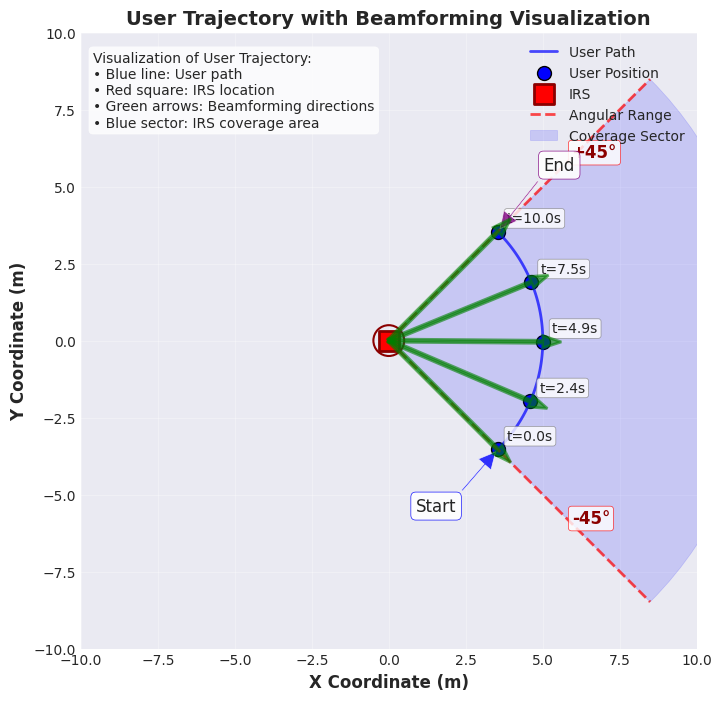

In [ ]:
#USER LOCATION AND ANGLE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Set the style using Seaborn
sns.set_style("darkgrid")

# Generate sample user trajectory data
def generate_trajectory(duration=10.0, sample_rate=10):
    """Generate a circular trajectory for the user"""
    time = np.linspace(0, duration, int(duration * sample_rate))
    radius = 5  # Radius of the circular trajectory
    angle = np.linspace(-np.pi/4, np.pi/4, len(time))  # Angle range for the trajectory
    x = radius * np.cos(angle)  # X-coordinates
    y = radius * np.sin(angle)  # Y-coordinates
    return np.column_stack((x, y)), time

# Generate trajectory data
trajectory, time = generate_trajectory()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the user trajectory
ax.plot(
    trajectory[:, 0],  # X-coordinates
    trajectory[:, 1],  # Y-coordinates
    'b-',  # Blue solid line
    linewidth=2,
    alpha=0.7,
    label='User Path'
)

# Add scatter points for user positions at specific time steps
sample_indices = np.linspace(0, len(trajectory)-1, 5, dtype=int)  # Sample 5 points
ax.scatter(
    trajectory[sample_indices, 0],
    trajectory[sample_indices, 1],
    c='blue',  # Color of scatter points
    s=100,  # Size of scatter points
    edgecolor='k',  # Black edge color
    linewidth=1,
    label='User Position'
)

# Add time stamps for sampled points
for idx in sample_indices:
    ax.text(
        trajectory[idx, 0] + 0.3,  # X offset for text
        trajectory[idx, 1] + 0.3,  # Y offset for text
        f"t={time[idx]:.1f}s",  # Time stamp
        fontsize=10,
        bbox=dict(
            boxstyle="round,pad=0.2",
            fc='white',
            ec="gray",
            alpha=0.8
        )
    )

# Add IRS location (0, 0)
ax.scatter(
    0, 0,  # IRS coordinates
    marker='s',  # Square marker
    s=200,  # Size of marker
    color='red',  # Color of marker
    edgecolor='darkred',  # Edge color
    linewidth=2,
    label='IRS'
)

# Add a fancy IRS symbol (circle around the IRS)
irs_circle = patches.Circle(
    (0, 0),  # Center of the circle
    0.5,  # Radius of the circle
    fill=False,  # No fill
    color='darkred',  # Circle color
    linestyle='-',  # Solid line
    linewidth=1.5
)
ax.add_patch(irs_circle)

# Draw angle bounds (coverage sector)
angle_line_length = 12  # Length of the angle lines
ax.plot(
    [0, angle_line_length * np.cos(np.pi/4)],  # X-coordinates for +45° line
    [0, angle_line_length * np.sin(np.pi/4)],  # Y-coordinates for +45° line
    'r--',  # Red dashed line
    alpha=0.7,
    linewidth=2,
    label='Angular Range'
)
ax.plot(
    [0, angle_line_length * np.cos(-np.pi/4)],  # X-coordinates for -45° line
    [0, angle_line_length * np.sin(-np.pi/4)],  # Y-coordinates for -45° line
    'r--',  # Red dashed line
    alpha=0.7,
    linewidth=2
)

# Add angle labels
ax.text(
    angle_line_length * np.cos(np.pi/4) * 0.7,  # X position for +45° label
    angle_line_length * np.sin(np.pi/4) * 0.7,  # Y position for +45° label
    "+45°",  # Label text
    fontsize=12,
    color='darkred',
    fontweight='bold',
    bbox=dict(
        boxstyle="round,pad=0.2",
        fc='white',
        ec="red",
        alpha=0.8
    )
)
ax.text(
    angle_line_length * np.cos(-np.pi/4) * 0.7,  # X position for -45° label
    angle_line_length * np.sin(-np.pi/4) * 0.7,  # Y position for -45° label
    "-45°",  # Label text
    fontsize=12,
    color='darkred',
    fontweight='bold',
    bbox=dict(
        boxstyle="round,pad=0.2",
        fc='white',
        ec="red",
        alpha=0.8
    )
)

# Add coverage sector visualization
sector = patches.Wedge(
    (0, 0),  # Center of the sector
    angle_line_length,  # Radius of the sector
    -45,  # Start angle (degrees)
    45,  # End angle (degrees)
    alpha=0.15,  # Transparency
    color='blue',  # Sector color
    label='Coverage Sector'
)
ax.add_patch(sector)

# Add beamforming arrows at specific time points
beam_sample_indices = np.linspace(0, len(trajectory)-1, 5, dtype=int)  # Sample 5 points
for idx in beam_sample_indices:
    # Calculate beam direction (from IRS to user)
    beam_x = trajectory[idx, 0]
    beam_y = trajectory[idx, 1]

    # Draw beam with fancy arrow
    ax.arrow(
        0, 0,  # Start point (IRS location)
        beam_x, beam_y,  # End point (user location)
        color='green',  # Arrow color
        width=0.1,  # Arrow width
        head_width=0.4,  # Arrowhead width
        head_length=0.6,  # Arrowhead length
        alpha=0.6,  # Transparency
        linewidth=2,
        zorder=5  # Ensure arrows are on top
    )

# Add key annotations
# Mark starting point
ax.annotate(
    'Start',
    xy=(trajectory[0, 0], trajectory[0, 1]),  # Coordinates of the starting point
    xytext=(trajectory[0, 0] - 2, trajectory[0, 1] - 2),  # Text position
    arrowprops=dict(
        facecolor='blue',
        shrink=0.05,
        width=1,
        alpha=0.8
    ),
    fontsize=12,
    ha='center',
    bbox=dict(
        boxstyle="round,pad=0.3",
        fc='white',
        ec="blue",
        alpha=0.9
    )
)

# Mark ending point
ax.annotate(
    'End',
    xy=(trajectory[-1, 0], trajectory[-1, 1]),  # Coordinates of the ending point
    xytext=(trajectory[-1, 0] + 2, trajectory[-1, 1] + 2),  # Text position
    arrowprops=dict(
        facecolor='purple',
        shrink=0.05,
        width=1,
        alpha=0.8
    ),
    fontsize=12,
    ha='center',
    bbox=dict(
        boxstyle="round,pad=0.3",
        fc='white',
        ec="purple",
        alpha=0.9
    )
)

# Enhance plot styling
ax.set_xlabel('X Coordinate (m)', fontweight='bold')
ax.set_ylabel('Y Coordinate (m)', fontweight='bold')
ax.set_title('User Trajectory with Beamforming Visualization', fontsize=14, fontweight='bold')
ax.set_aspect('equal')  # Ensure equal scaling for X and Y axes
ax.set_xlim(-10, 10)  # Set X-axis limits
ax.set_ylim(-10, 10)  # Set Y-axis limits
ax.grid(True, alpha=0.3)  # Add grid with transparency
ax.legend(loc='upper right')  # Add legend

# Add explanation box
explanation_text = (
    "Visualization of User Trajectory:\n"
    "• Blue line: User path\n"
    "• Red square: IRS location\n"
    "• Green arrows: Beamforming directions\n"
    "• Blue sector: IRS coverage area"
)
ax.text(
    0.02, 0.97,  # Position of the text box
    explanation_text,
    transform=ax.transAxes,  # Use axis coordinates
    fontsize=10,
    va='top',
    ha='left',
    bbox=dict(
        boxstyle='round',
        facecolor='white',
        alpha=0.8
    )
)

# Save the figure
plt.savefig('user_trajectory_visualization.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()